# Random Forest modelio tyrimas trūkstamų ekonominių rodiklių užpildymui NUTS-2 lygmeniu

**Autorius:** Irmantas Pilypas
**Institucija:** Vilniaus universiteto Šiaulių akademija
**Data:** 2025

---

## Tyrimo aprašymas

Šis tyrimas analizuoja Random Forest algoritmo efektyvumą užpildant trūkstamas ekonominių rodiklių reikšmes ES NUTS-2 regionų lygmeniu.

**Tyrime naudojami duomenys:**
- **260 regionų** (NUTS-2 lygmuo)
- **8 ekonominiai rodikliai**
- **Laikotarpis:** 1990-2023 metai
- **Iš viso:** 10,383 įrašai

**Vertinimo metrikos:**
- R² (Coefficient of Determination)
- RMSE (Root Mean Squared Error)
- MAE (Mean Absolute Error)
- MAPE (Mean Absolute Percentage Error)

## 1. Aplinkos paruošimas

Importuojame reikalingas bibliotekas duomenų analizei ir vizualizacijai. Machine Learning modelis naudojamas iš `modeliai/` direktorijos.

In [1]:
# ============================================================================
# BIBLIOTEKŲ IMPORTAVIMAS
# ============================================================================

# Duomenų apdorojimo bibliotekos
import pandas as pd
import numpy as np
import warnings

# Vizualizacijos bibliotekos
import matplotlib.pyplot as plt
import seaborn as sns

# Random Forest modelis iš Flask aplikacijos
import sys
sys.path.append('.')
from modeliai.Random_Forest import RandomForestImputer

# Konfigūracija
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.unicode_minus'] = False

# Random seed reprodukuojamumui (kaip Flask aplikacijoje)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ Visos bibliotekos sėkmingai importuotos")
print("✓ RandomForestImputer klasė importuota iš modeliai/Random_Forest.py")

✓ Visos bibliotekos sėkmingai importuotos
✓ RandomForestImputer klasė importuota iš modeliai/Random_Forest.py


## 2. Duomenų įkėlimas ir pirminė apžvalga

In [2]:
# ============================================================================
# DUOMENŲ ĮKĖLIMAS
# ============================================================================

# Duomenų failo kelias
DATA_PATH = 'uploads/Gretos_8_ekonominiai_rodikliai.csv'

# Įkeliame duomenis
df = pd.read_csv(DATA_PATH)

print(f"✓ Duomenys įkelti: {len(df):,} eilučių, {len(df.columns)} stulpelių")
print(f"\nStulpeliai: {', '.join(df.columns)}")
print(f"\nPirmosios 5 eilutės:")
display(df.head())

# Duomenų tipai
print(f"\nDuomenų tipai:")
print(df.dtypes)

✓ Duomenys įkelti: 10,383 eilučių, 10 stulpelių

Stulpeliai: geo, time_period, population_density, hospital_beds, at_risk_of_poverty, low_work_intensity, gdp_current_prices, rd_expenditure, internet_access, tertiary_education

Pirmosios 5 eilutės:


,geo,time_period,population_density,hospital_beds,at_risk_of_poverty,low_work_intensity,gdp_current_prices,rd_expenditure,internet_access,tertiary_education
0,AL,2017,NaN,NaN,23.7,NaN,NaN,NaN,NaN,NaN
1,AL,2018,NaN,NaN,23.4,NaN,NaN,NaN,NaN,NaN
2,AL,2019,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN
3,AL,2020,NaN,NaN,21.8,NaN,NaN,NaN,NaN,NaN
4,AL,2021,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN



Duomenų tipai:
geo                    object
time_period             int64
population_density    float64
hospital_beds         float64
at_risk_of_poverty    float64
low_work_intensity    float64
gdp_current_prices    float64
rd_expenditure        float64
internet_access       float64
tertiary_education    float64
dtype: object


## 3. Tyrimo duomenų analizė (EDA)

### 3.1 Trūkstamų reikšmių analizė

In [3]:
# ============================================================================
# TRŪKSTAMŲ REIKŠMIŲ ANALIZĖ
# ============================================================================

# Skaičiuojame trūkstamas reikšmes
missing_counts = df.isnull().sum()
missing_pct = (missing_counts / len(df)) * 100

missing_df = pd.DataFrame({
    'Stulpelis': df.columns,
    'Trūkstamų kiekis': missing_counts,
    'Trūkstamų (%)': missing_pct,
    'Užpildytų': len(df) - missing_counts
}).sort_values('Trūkstamų (%)', ascending=False)

print("=" * 80)
print("TRŪKSTAMŲ REIKŠMIŲ SUVESTINĖ")
print("=" * 80)
display(missing_df)

total_missing = df.isnull().sum().sum()
total_cells = df.shape[0] * df.shape[1]
print(f"\nIš viso trūkstamų reikšmių: {total_missing:,} ({total_missing/total_cells*100:.2f}%)")

TRŪKSTAMŲ REIKŠMIŲ SUVESTINĖ


,Stulpelis,Trūkstamų kiekis,Trūkstamų (%),Užpildytų
rd_expenditure,rd_expenditure,8265,79.601271,2118
low_work_intensity,low_work_intensity,8259,79.543485,2124
internet_access,internet_access,8256,79.514591,2127
hospital_beds,hospital_beds,6863,66.098430,3520
tertiary_education,tertiary_education,6653,64.075893,3730
at_risk_of_poverty,at_risk_of_poverty,6021,57.989021,4362
gdp_current_prices,gdp_current_prices,4699,45.256670,5684
population_density,population_density,3375,32.505056,7008
time_period,time_period,0,0.000000,10383
geo,geo,0,0.000000,10383



Iš viso trūkstamų reikšmių: 52,391 (50.46%)


### 3.2 Koreliacijos matrica

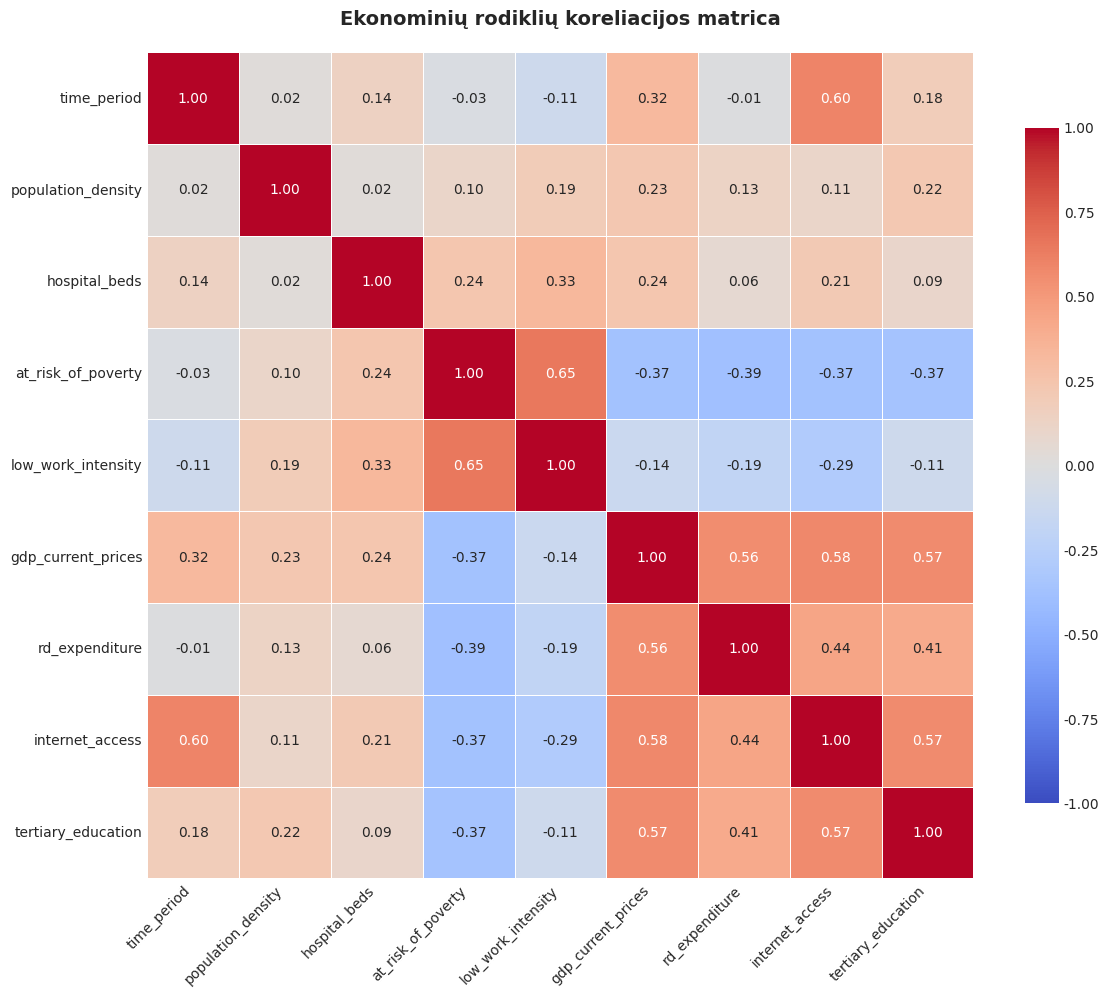

In [4]:
# ============================================================================
# KORELIACIJOS MATRICA
# ============================================================================

# Pasirenkame tik skaitinius stulpelius
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = df[numeric_cols].corr()

# Vizualizacija
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title('Ekonominių rodiklių koreliacijos matrica', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 3.3 Trūkstamų reikšmių vizualizacija

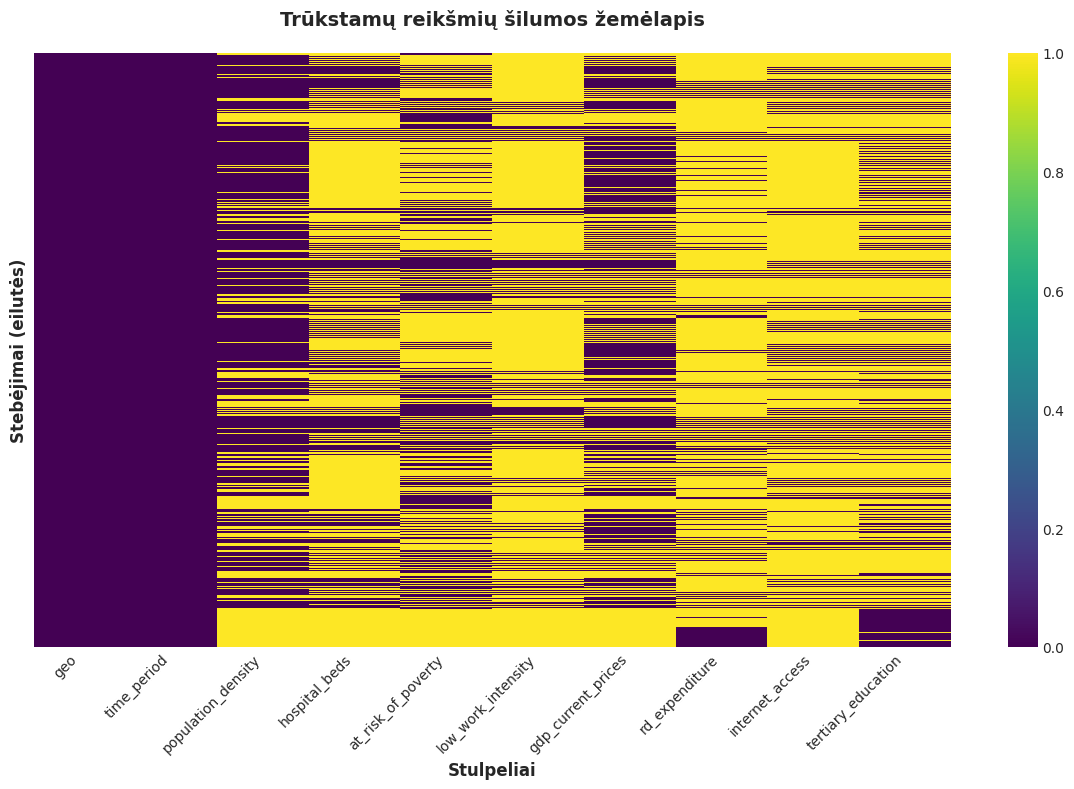

Vizualizuota 10,383 eilučių su 10 stulpeliais


In [5]:
# ============================================================================
# TRŪKSTAMŲ REIKŠMIŲ ŠILUMOS ŽEMĖLAPIS
# ============================================================================

plt.figure(figsize=(12, 8))
sns.heatmap(
    df.isnull(),
    yticklabels=False,
    cbar=True,
    cmap='viridis'
)
plt.title('Trūkstamų reikšmių šilumos žemėlapis', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Stulpeliai', fontsize=12, fontweight='bold')
plt.ylabel('Stebėjimai (eilutės)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"Vizualizuota {len(df):,} eilučių su {len(df.columns)} stulpeliais")

## 4. Random Forest modelio implementacija

### 4.1 Modelio treniravimas

Naudojame `RandomForestImputer` klasę iš Flask aplikacijos su šiais parametrais:
- **n_estimators:** 100
- **random_state:** 42
- **min_samples_split:** 5
- **min_samples_leaf:** 2
- **max_features:** 'sqrt'

In [6]:
# ============================================================================
# RANDOM FOREST MODELIO TRENIRAVIMAS
# ============================================================================

print("=" * 80)
print("RANDOM FOREST MODELIO TRENIRAVIMAS")
print("=" * 80)
print(f"\nParametrai:")
print(f"  - n_estimators: 100")
print(f"  - random_state: 42")
print(f"  - min_samples_split: 5")
print(f"  - min_samples_leaf: 2")
print(f"  - max_features: 'sqrt'")
print()

# Sukuriame modelį
rf_imputer = RandomForestImputer(n_estimators=100, random_state=42)

# Išsaugome originalius duomenis
df_original = df.copy()

# Užpildome trūkstamas reikšmes
print(f"Trūkstamų reikšmių prieš: {df.isnull().sum().sum():,}")
df_imputed_rf = rf_imputer.fit_and_impute(df.copy())
print(f"Trūkstamų reikšmių po: {df_imputed_rf.isnull().sum().sum():,}")
print()
print("=" * 80)
print("✓ MODELIO TRENIRAVIMAS BAIGTAS")
print("=" * 80)

RANDOM FOREST MODELIO TRENIRAVIMAS

Parametrai:
  - n_estimators: 100
  - random_state: 42
  - min_samples_split: 5
  - min_samples_leaf: 2
  - max_features: 'sqrt'

Trūkstamų reikšmių prieš: 52,391
Trūkstamų reikšmių po: 0

✓ MODELIO TRENIRAVIMAS BAIGTAS


### 4.1.1 Užpildytų duomenų išsaugojimas

Išsaugome užpildytus duomenis į CSV failą, kaip Flask aplikacijoje.

In [7]:
# ============================================================================
# UŽPILDYTŲ DUOMENŲ IŠSAUGOJIMAS
# ============================================================================

import os
from datetime import datetime

# Sukuriame failo pavadinimą (kaip Flask aplikacijoje)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
base_name = 'Gretos_8_ekonominiai_rodikliai'
model_type = 'random_forest'

# Išsaugojimo kelias
output_dir = 'uploads'
os.makedirs(output_dir, exist_ok=True)

imputed_filename = f"{base_name}_imputed_{model_type}_{timestamp}.csv"
imputed_filepath = os.path.join(output_dir, imputed_filename)

# Išsaugome užpildytus duomenis
df_imputed_rf.to_csv(imputed_filepath, index=False)

print("=" * 80)
print("UŽPILDYTI DUOMENYS IŠSAUGOTI")
print("=" * 80)
print(f"Failo pavadinimas: {imputed_filename}")
print(f"Pilnas kelias: {imputed_filepath}")
print(f"Duomenų statistika:")
print(f"  - Eilučių: {len(df_imputed_rf):,}")
print(f"  - Stulpelių: {len(df_imputed_rf.columns)}")
print(f"  - Trūkstamų reikšmių: {df_imputed_rf.isnull().sum().sum()}")
print(f"  - Failo dydis: {os.path.getsize(imputed_filepath) / 1024:.2f} KB")
print()
print("=" * 80)

UŽPILDYTI DUOMENYS IŠSAUGOTI
Failo pavadinimas: Gretos_8_ekonominiai_rodikliai_imputed_random_forest_20251015_232351.csv
Pilnas kelias: uploads\Gretos_8_ekonominiai_rodikliai_imputed_random_forest_20251015_232351.csv
Duomenų statistika:
  - Eilučių: 10,383
  - Stulpelių: 10
  - Trūkstamų reikšmių: 0
  - Failo dydis: 1226.27 KB



### 4.2 Modelio metrikų analizė

In [8]:
# ============================================================================
# MODELIO METRIKŲ ANALIZĖ
# ============================================================================

# Gauname metrikas
rf_metrics = rf_imputer.get_model_metrics()

print("=" * 90)
print("RANDOM FOREST - METRIKOS KIEKVIENAM RODIKLIUI")
print("=" * 90)

# Sukuriame suvestinę lentelę
metrics_list = []

for rodiklis, metrics in rf_metrics.items():
    if metrics.get('model_type') == 'regression':
        metrics_list.append({
            'Rodiklis': rodiklis,
            'R²': metrics['r2'],
            'RMSE': metrics['rmse'],
            'MAE': metrics['mae'],
            'MAPE (%)': metrics['mape'],
            'Imtis': metrics['sample_size']
        })

        print(f"\n{rodiklis}:")
        print(f"  R²: {metrics['r2']:.4f}")
        print(f"  RMSE: {metrics['rmse']:.2f}")
        print(f"  MAE: {metrics['mae']:.2f}")
        print(f"  MAPE: {metrics['mape']:.2f}%")
        print(f"  Imtis: {metrics['sample_size']:,}")

rf_metrics_df = pd.DataFrame(metrics_list)

print(f"\n{'=' * 90}")
print("SUVESTINĖ LENTELĖ")
print("=" * 90)
display(rf_metrics_df)

# Statistika
valid_r2 = rf_metrics_df['R²'].dropna()
print(f"\n{'=' * 90}")
print(f"STATISTIKA:")
print(f"  - Vidutinis R²: {valid_r2.mean():.4f}")
print(f"  - Geriausias: {rf_metrics_df.loc[rf_metrics_df['R²'].idxmax(), 'Rodiklis']} (R²={valid_r2.max():.4f})")
print(f"  - Blogiausias: {rf_metrics_df.loc[rf_metrics_df['R²'].idxmin(), 'Rodiklis']} (R²={valid_r2.min():.4f})")
print("=" * 90)

RANDOM FOREST - METRIKOS KIEKVIENAM RODIKLIUI

population_density:
  R²: 0.8819
  RMSE: 334.65
  MAE: 128.17
  MAPE: 122.81%
  Imtis: 1,402

hospital_beds:
  R²: 0.8890
  RMSE: 32.85
  MAE: 19.62
  MAPE: 9.08%
  Imtis: 704

at_risk_of_poverty:
  R²: 0.8100
  RMSE: 2.97
  MAE: 2.04
  MAPE: 13.68%
  Imtis: 873

low_work_intensity:
  R²: 0.7804
  RMSE: 2.21
  MAE: 1.65
  MAPE: 22.07%
  Imtis: 425

gdp_current_prices:
  R²: 0.9181
  RMSE: 4118.23
  MAE: 2288.12
  MAPE: 11.13%
  Imtis: 1,137

rd_expenditure:
  R²: 0.2926
  RMSE: 1.95
  MAE: 0.40
  MAPE: 0.00%
  Imtis: 424

internet_access:
  R²: 0.8978
  RMSE: 3.14
  MAE: 2.32
  MAPE: 2.86%
  Imtis: 426

tertiary_education:
  R²: 0.8936
  RMSE: 3.48
  MAE: 2.38
  MAPE: 8.35%
  Imtis: 746

SUVESTINĖ LENTELĖ


,Rodiklis,R²,RMSE,MAE,MAPE (%),Imtis
0,population_density,0.881866,334.650751,128.165461,122.808742,1402
1,hospital_beds,0.889020,32.851497,19.619438,9.075483,704
2,at_risk_of_poverty,0.810045,2.973622,2.041784,13.684664,873
3,low_work_intensity,0.780358,2.211528,1.648647,22.071103,425
4,gdp_current_prices,0.918111,4118.227941,2288.116736,11.125873,1137
5,rd_expenditure,0.292604,1.953170,0.402074,0.000000,424
6,internet_access,0.897780,3.138576,2.324727,2.859500,426
7,tertiary_education,0.893569,3.484329,2.384427,8.349524,746



STATISTIKA:
  - Vidutinis R²: 0.7954
  - Geriausias: gdp_current_prices (R²=0.9181)
  - Blogiausias: rd_expenditure (R²=0.2926)


### 4.3 Požymių svarbos analizė

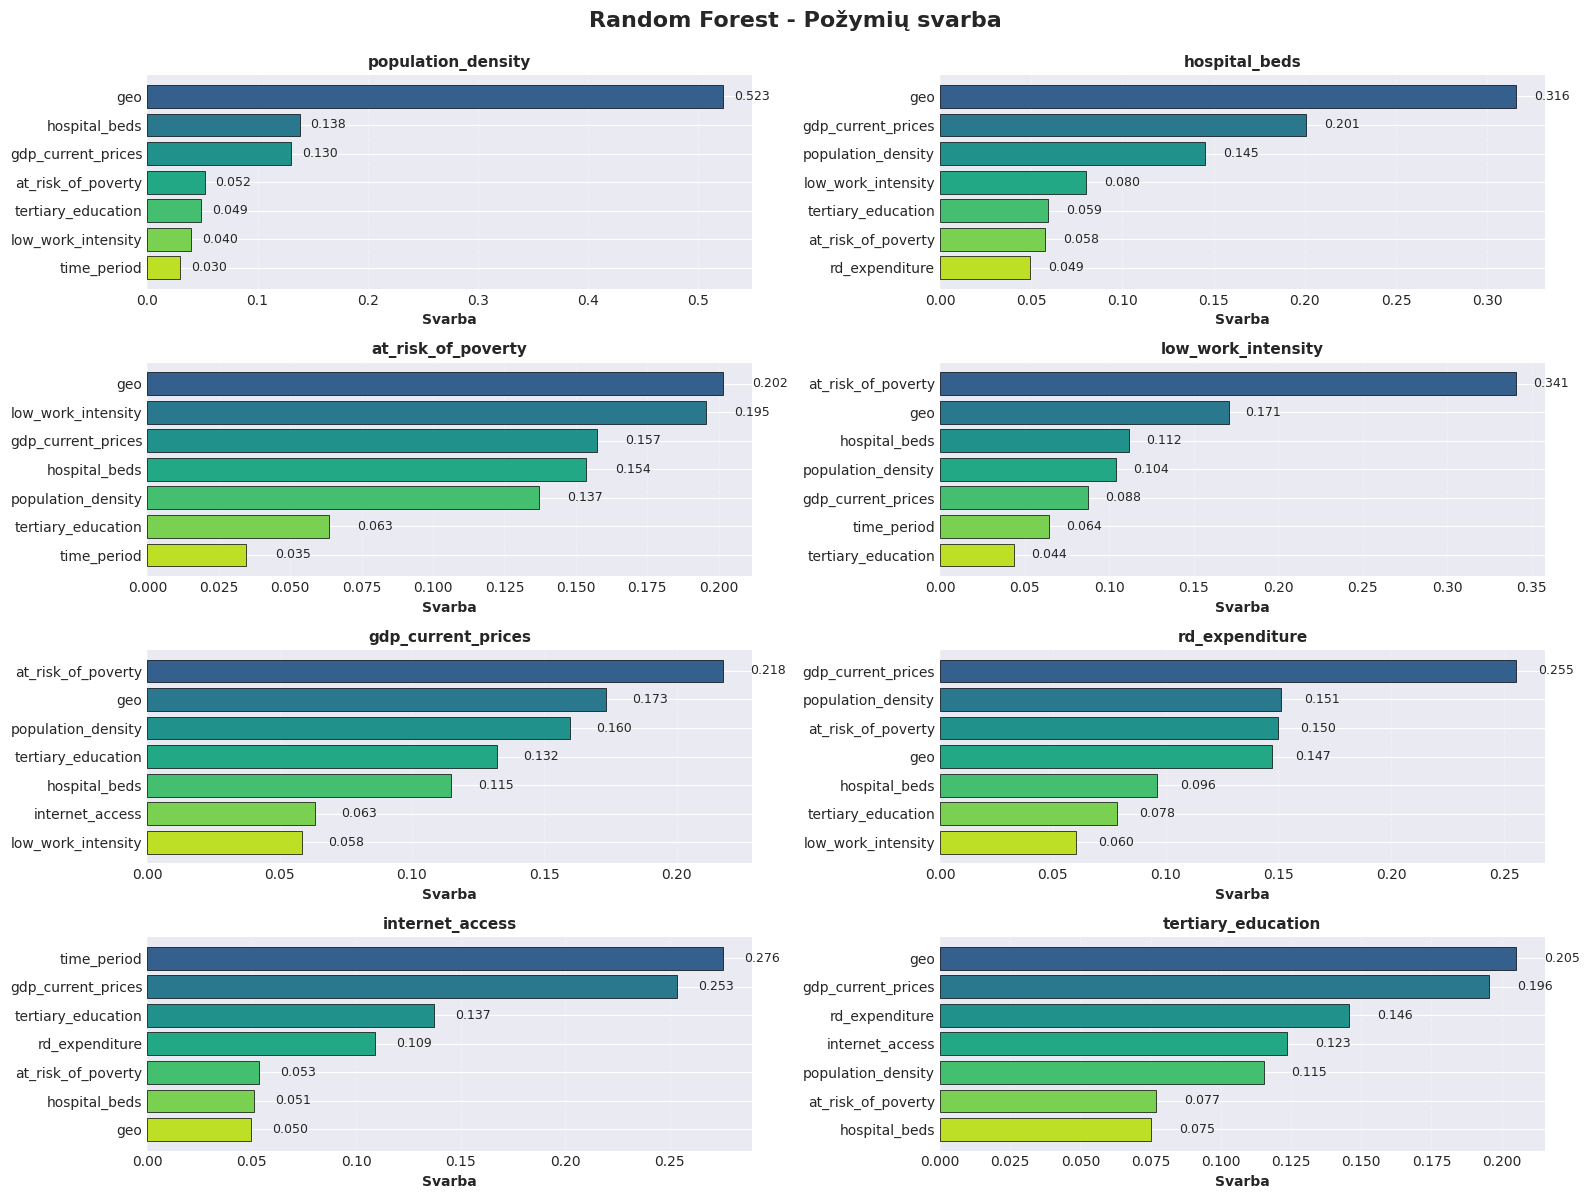

Išanalizuota 8 rodiklių


In [9]:
# ============================================================================
# POŽYMIŲ SVARBOS VIZUALIZACIJA
# ============================================================================

rf_feature_importance = rf_imputer.get_feature_importance()

# Gauname ekonominius rodiklius
indicators = [k for k in rf_feature_importance.keys() if k not in ['geo', 'time_period']]

# Sukuriame subplot'us
n_cols = 2
n_rows = (len(indicators) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))
axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes

for idx, indicator in enumerate(indicators):
    ax = axes[idx]
    importance_dict = rf_feature_importance[indicator]

    # Konvertuojame į DataFrame
    imp_df = pd.DataFrame(
        list(importance_dict.items()),
        columns=['Požymis', 'Svarba']
    ).sort_values('Svarba', ascending=False).head(7)

    # Braižome
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(imp_df)))
    bars = ax.barh(range(len(imp_df)), imp_df['Svarba'], color=colors, edgecolor='black', linewidth=0.5)

    ax.set_yticks(range(len(imp_df)))
    ax.set_yticklabels(imp_df['Požymis'])
    ax.set_xlabel('Svarba', fontsize=10, fontweight='bold')
    ax.set_title(indicator, fontsize=11, fontweight='bold')
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.invert_yaxis()

    # Pridedame reikšmes
    for i, (bar, val) in enumerate(zip(bars, imp_df['Svarba'])):
        ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=9)

# Išjungiame nepanaudotus
for idx in range(len(indicators), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Random Forest - Požymių svarba', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print(f"Išanalizuota {len(indicators)} rodiklių")

### 4.4 R² reikšmių vizualizacija

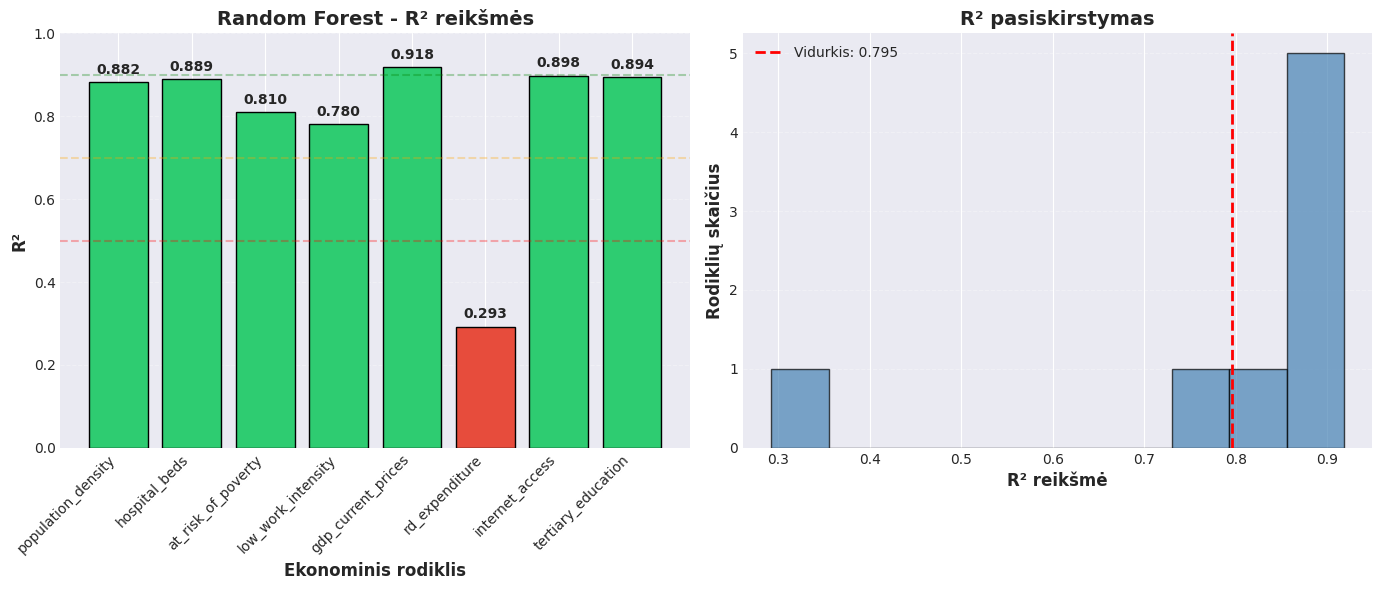

In [10]:
# ============================================================================
# R² REIKŠMIŲ VIZUALIZACIJA
# ============================================================================

valid_df = rf_metrics_df.dropna(subset=['R²']).copy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Stulpelinė diagrama
colors = valid_df['R²'].apply(lambda x: '#2ecc71' if x >= 0.7 else '#f39c12' if x >= 0.5 else '#e74c3c')
bars = ax1.bar(range(len(valid_df)), valid_df['R²'], color=colors, edgecolor='black', linewidth=1)

ax1.set_xlabel('Ekonominis rodiklis', fontsize=12, fontweight='bold')
ax1.set_ylabel('R²', fontsize=12, fontweight='bold')
ax1.set_title('Random Forest - R² reikšmės', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(valid_df)))
ax1.set_xticklabels(valid_df['Rodiklis'], rotation=45, ha='right')
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.axhline(y=0.9, color='green', linestyle='--', alpha=0.3)
ax1.axhline(y=0.7, color='orange', linestyle='--', alpha=0.3)
ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.3)

for bar, val in zip(bars, valid_df['R²']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{val:.3f}', ha='center', fontsize=10, fontweight='bold')

# Histograma
ax2.hist(valid_df['R²'], bins=10, color='steelblue', edgecolor='black', alpha=0.7)
ax2.set_xlabel('R² reikšmė', fontsize=12, fontweight='bold')
ax2.set_ylabel('Rodiklių skaičius', fontsize=12, fontweight='bold')
ax2.set_title('R² pasiskirstymas', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.axvline(x=valid_df['R²'].mean(), color='red', linestyle='--', linewidth=2,
            label=f'Vidurkis: {valid_df["R²"].mean():.3f}')
ax2.legend()

plt.tight_layout()
plt.show()

### 4.5 Išvados

In [11]:
# ============================================================================
# RANDOM FOREST MODELIO IŠVADOS
# ============================================================================

print("=" * 90)
print("RANDOM FOREST MODELIO IŠVADOS")
print("=" * 90)

valid_r2 = rf_metrics_df['R²'].dropna()

r2_excellent = (valid_r2 >= 0.9).sum()
r2_good = ((valid_r2 >= 0.7) & (valid_r2 < 0.9)).sum()
r2_medium = ((valid_r2 >= 0.5) & (valid_r2 < 0.7)).sum()
r2_poor = (valid_r2 < 0.5).sum()

print(f"\n1. MODELIO EFEKTYVUMAS:")
print(f"   - Vidutinis R²: {valid_r2.mean():.4f}")
print(f"   - Mediana: {valid_r2.median():.4f}")
print(f"   - Standartinis nuokrypis: {valid_r2.std():.4f}")

print(f"\n2. R² PASISKIRSTYMAS:")
print(f"   - Puikus (R² ≥ 0.9): {r2_excellent} rodikliai")
print(f"   - Geras (0.7 ≤ R² < 0.9): {r2_good} rodikliai")
print(f"   - Vidutinis (0.5 ≤ R² < 0.7): {r2_medium} rodikliai")
print(f"   - Silpnas (R² < 0.5): {r2_poor} rodikliai")

best_idx = rf_metrics_df['R²'].idxmax()
worst_idx = rf_metrics_df['R²'].idxmin()

print(f"\n3. EKSTREMALŪS ATVEJAI:")
print(f"   Geriausias: {rf_metrics_df.loc[best_idx, 'Rodiklis']} (R²={rf_metrics_df.loc[best_idx, 'R²']:.4f})")
print(f"   Blogiausias: {rf_metrics_df.loc[worst_idx, 'Rodiklis']} (R²={rf_metrics_df.loc[worst_idx, 'R²']:.4f})")

print(f"\n4. BENDROJI IŠVADA:")
if valid_r2.mean() >= 0.7:
    print(f"   ✓ Random Forest pasiekia gerą tikslumą (vid. R² ≥ 0.7)")
elif valid_r2.mean() >= 0.5:
    print(f"   ≈ Random Forest pasiekia vidutinį tikslumą (vid. R² ≥ 0.5)")
else:
    print(f"   ✗ Random Forest pasiekia silpną tikslumą (vid. R² < 0.5)")

print(f"\n   • Užpildyta {len(valid_r2)}/{len(rf_metrics_df)} ekonominių rodiklių")
print(f"\n{'=' * 90}")

RANDOM FOREST MODELIO IŠVADOS

1. MODELIO EFEKTYVUMAS:
   - Vidutinis R²: 0.7954
   - Mediana: 0.8854
   - Standartinis nuokrypis: 0.2086

2. R² PASISKIRSTYMAS:
   - Puikus (R² ≥ 0.9): 1 rodikliai
   - Geras (0.7 ≤ R² < 0.9): 6 rodikliai
   - Vidutinis (0.5 ≤ R² < 0.7): 0 rodikliai
   - Silpnas (R² < 0.5): 1 rodikliai

3. EKSTREMALŪS ATVEJAI:
   Geriausias: gdp_current_prices (R²=0.9181)
   Blogiausias: rd_expenditure (R²=0.2926)

4. BENDROJI IŠVADA:
   ✓ Random Forest pasiekia gerą tikslumą (vid. R² ≥ 0.7)

   • Užpildyta 8/8 ekonominių rodiklių



FAKTINIŲ IR PROGNOZUOTŲ REIKŠMIŲ PALYGINIMAS - RANDOM FOREST



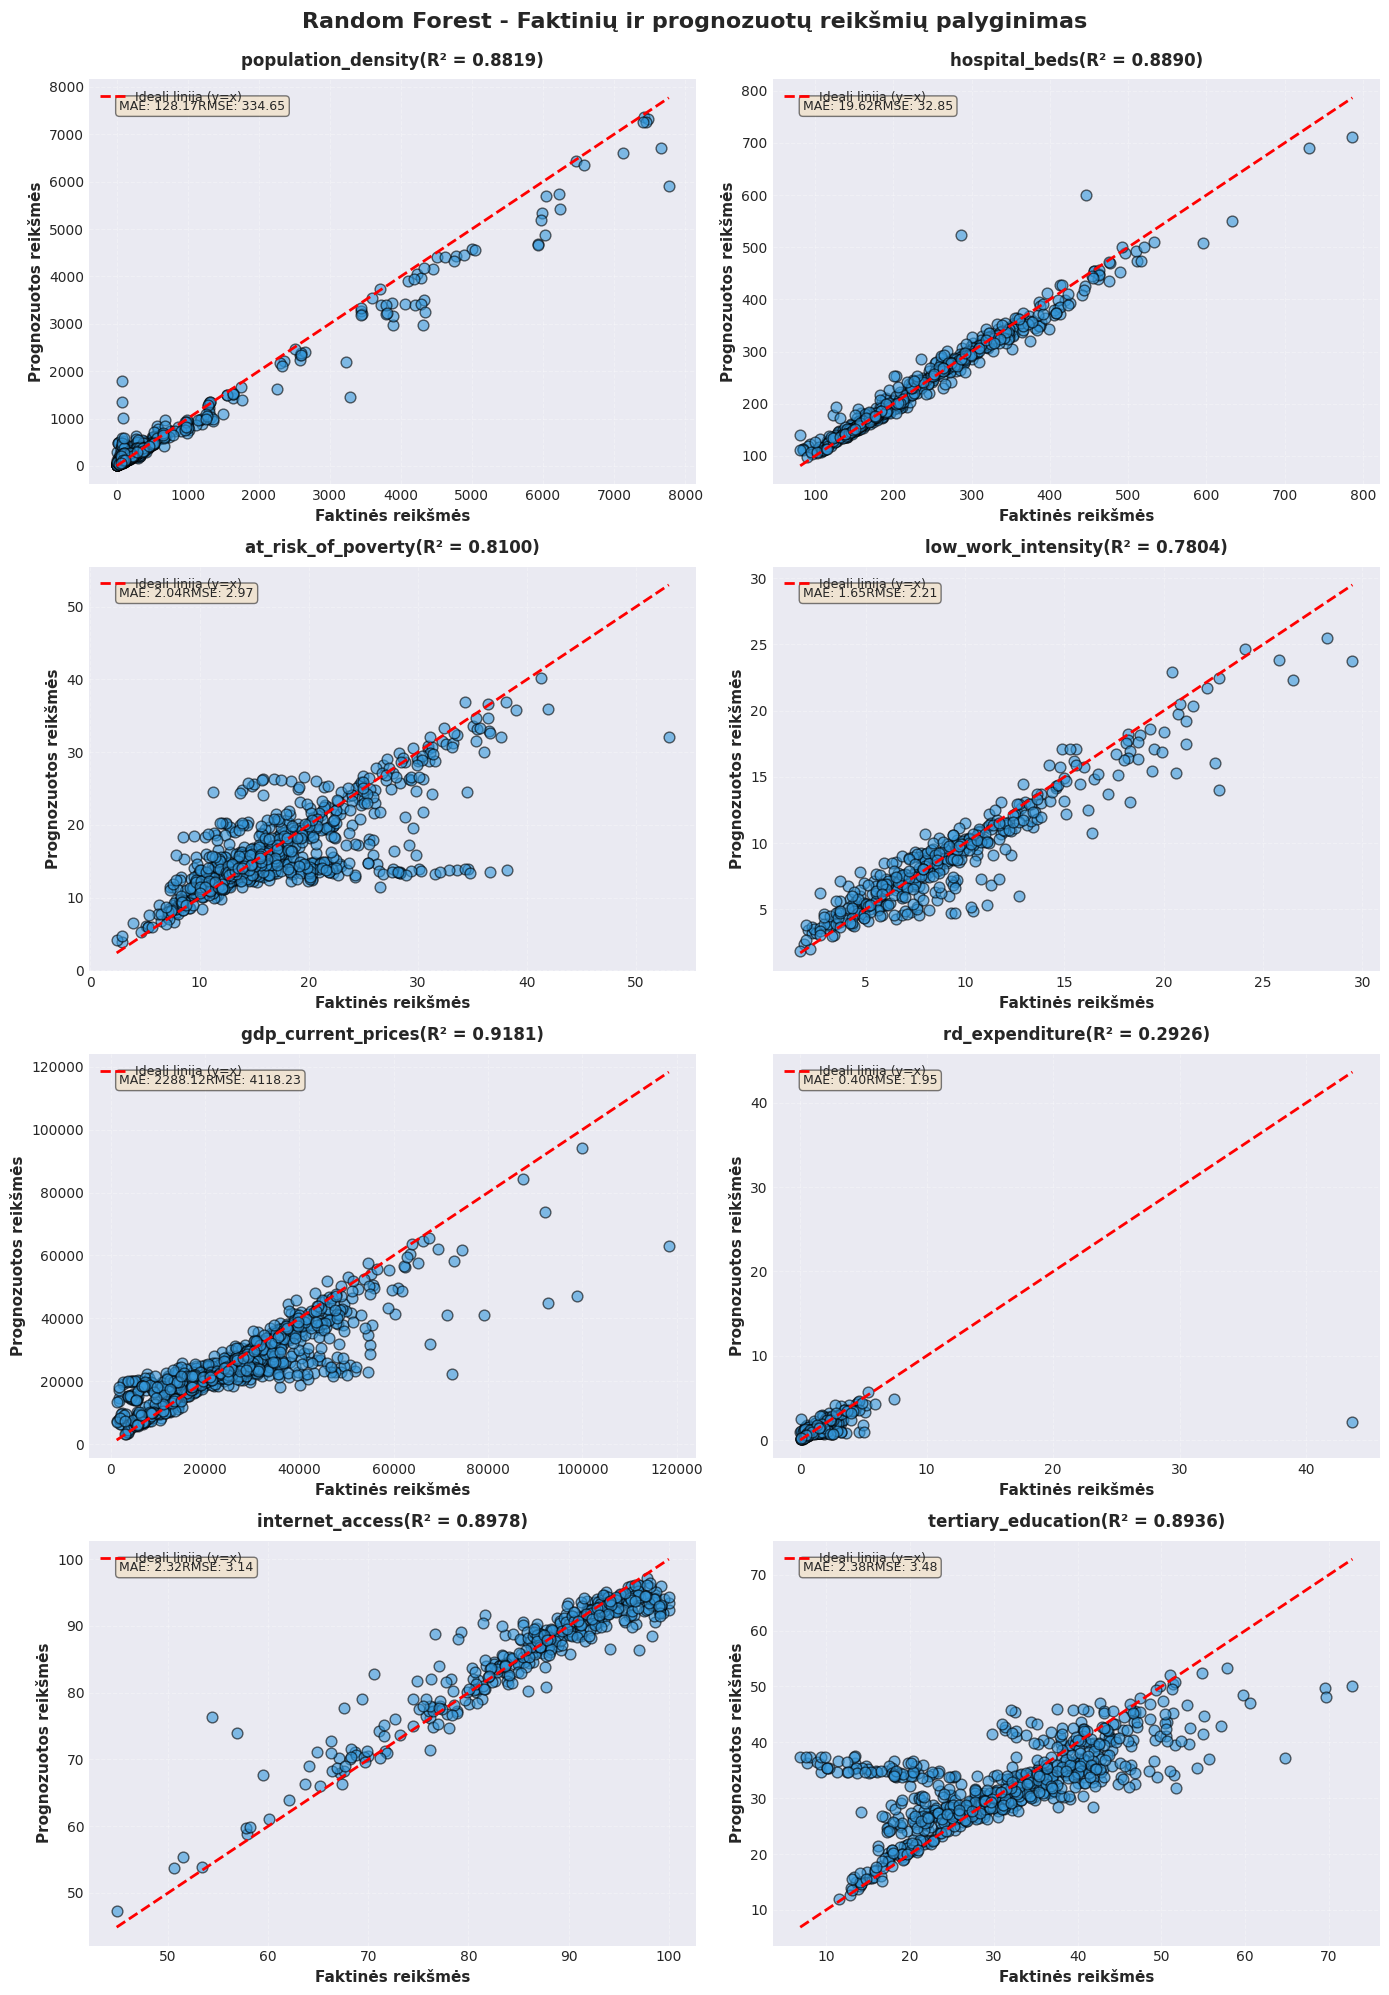


IŠVADA:
Scatter plot grafikai rodo modelio prognozavimo tikslumą:
  • Taškai arčiau raudonos linijos (y=x) = geresnis prognozavimas
  • R² artimas 1.0 = labai tikslus modelis
  • Taškai išsisklaidę = modelis turi sunkumų prognozuojant


In [12]:
# ============================================================================
# FAKTINIŲ IR PROGNOZUOTŲ REIKŠMIŲ PALYGINIMAS (RANDOM FOREST)
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np

print("=" * 100)
print("FAKTINIŲ IR PROGNOZUOTŲ REIKŠMIŲ PALYGINIMAS - RANDOM FOREST")
print("=" * 100)
print()

# Gauname predictions iš modelio (DRY principas - logika modelio klasėje)
rf_predictions_data = rf_imputer.get_test_predictions(df)

# Vizualizuojame rezultatus
if len(rf_predictions_data) > 0:
    n_indicators = len(rf_predictions_data)
    n_cols = 2
    n_rows = (n_indicators + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
    axes = axes.flatten() if n_indicators > 1 else [axes]
    
    for idx, (indicator, data) in enumerate(rf_predictions_data.items()):
        ax = axes[idx]
        y_test = data["y_test"]
        y_pred = data["y_pred"]
        r2 = data["r2"]
        
        # Scatter plot
        ax.scatter(y_test, y_pred, alpha=0.6, edgecolors="k", s=60, color="#3498db")
        
        # Ideali linija (y = x)
        min_val = min(y_test.min(), y_pred.min())
        max_val = max(y_test.max(), y_pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], "r--", lw=2, label="Ideali linija (y=x)")
        
        # Formatavimas
        ax.set_xlabel("Faktinės reikšmės", fontsize=11, fontweight="bold")
        ax.set_ylabel("Prognozuotos reikšmės", fontsize=11, fontweight="bold")
        ax.set_title(f"{indicator}(R² = {r2:.4f})", fontsize=12, fontweight="bold", pad=10)
        ax.legend(loc="upper left", fontsize=9)
        ax.grid(True, alpha=0.3, linestyle="--")
        
        # Pridedame tekstą su statistika
        mae = data.get("mae", np.mean(np.abs(y_test - y_pred)))  # Išsaugota arba perskaičiuota
        rmse = data.get("rmse", np.sqrt(np.mean((y_test - y_pred)**2)))  # Išsaugota arba perskaičiuota
        ax.text(0.05, 0.95, f"MAE: {mae:.2f}RMSE: {rmse:.2f}",
                transform=ax.transAxes, fontsize=9, verticalalignment="top",
                bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
    
    # Pašaliname tuščius subplot'us jei yra
    for idx in range(len(rf_predictions_data), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.suptitle("Random Forest - Faktinių ir prognozuotų reikšmių palyginimas",
                 fontsize=16, fontweight="bold", y=0.995)
    plt.tight_layout()
    plt.show()
else:
    print("Nerasta rodiklių, kuriems būtų galima sukurti scatter plots.")

print()
print("=" * 100)
print("IŠVADA:")
print("=" * 100)
print("Scatter plot grafikai rodo modelio prognozavimo tikslumą:")
print("  • Taškai arčiau raudonos linijos (y=x) = geresnis prognozavimas")
print("  • R² artimas 1.0 = labai tikslus modelis")
print("  • Taškai išsisklaidę = modelis turi sunkumų prognozuojant")
print("=" * 100)

## 5. XGBoost modelio implementacija

### 5.1 Modelio treniravimas

Naudojame `XGBoostImputer` klasę iš Flask aplikacijos su šiais parametrais:
- **n_estimators:** 100
- **random_state:** 42
- **learning_rate:** 0.1
- **max_depth:** 6
- **subsample:** 0.8
- **colsample_bytree:** 0.8
- **min_child_weight:** 3
- **reg_alpha:** 0.1
- **reg_lambda:** 0.1

In [13]:
# ============================================================================
# XGBOOST MODELIO TRENIRAVIMAS
# ============================================================================

# Importuojame XGBoostImputer
from modeliai.XGBoost import XGBoostImputer

print("=" * 80)
print("XGBOOST MODELIO TRENIRAVIMAS")
print("=" * 80)
print(f"\nParametrai:")
print(f"  - n_estimators: 100")
print(f"  - random_state: 42")
print(f"  - learning_rate: 0.1")
print(f"  - max_depth: 6")
print(f"  - subsample: 0.8")
print(f"  - colsample_bytree: 0.8")
print(f"  - min_child_weight: 3")
print(f"  - reg_alpha: 0.1")
print(f"  - reg_lambda: 0.1")
print()

# Sukuriame modelį
xgb_imputer = XGBoostImputer(n_estimators=100, random_state=42)

# Užpildome trūkstamas reikšmes
print(f"Trūkstamų reikšmių prieš: {df.isnull().sum().sum():,}")
df_imputed_xgb = xgb_imputer.fit_and_impute(df.copy())
print(f"Trūkstamų reikšmių po: {df_imputed_xgb.isnull().sum().sum():,}")
print()
print("=" * 80)
print("✓ XGBOOST MODELIO TRENIRAVIMAS BAIGTAS")
print("=" * 80)

XGBOOST MODELIO TRENIRAVIMAS

Parametrai:
  - n_estimators: 100
  - random_state: 42
  - learning_rate: 0.1
  - max_depth: 6
  - subsample: 0.8
  - colsample_bytree: 0.8
  - min_child_weight: 3
  - reg_alpha: 0.1
  - reg_lambda: 0.1

Trūkstamų reikšmių prieš: 52,391
Trūkstamų reikšmių po: 0

✓ XGBOOST MODELIO TRENIRAVIMAS BAIGTAS


### 5.1.1 Užpildytų duomenų išsaugojimas

In [14]:
# ============================================================================
# XGBOOST - UŽPILDYTŲ DUOMENŲ IŠSAUGOJIMAS
# ============================================================================

# Sukuriame failo pavadinimą
timestamp_xgb = datetime.now().strftime("%Y%m%d_%H%M%S")
model_type_xgb = 'xgboost'

imputed_filename_xgb = f"{base_name}_imputed_{model_type_xgb}_{timestamp_xgb}.csv"
imputed_filepath_xgb = os.path.join(output_dir, imputed_filename_xgb)

# Išsaugome
df_imputed_xgb.to_csv(imputed_filepath_xgb, index=False)

print("=" * 80)
print("XGBOOST - UŽPILDYTI DUOMENYS IŠSAUGOTI")
print("=" * 80)
print(f"\nFailo pavadinimas: {imputed_filename_xgb}")
print(f"Pilnas kelias: {imputed_filepath_xgb}")
print(f"\nDuomenų statistika:")
print(f"  - Eilučių: {len(df_imputed_xgb):,}")
print(f"  - Stulpelių: {len(df_imputed_xgb.columns)}")
print(f"  - Trūkstamų reikšmių: {df_imputed_xgb.isnull().sum().sum()}")
print(f"  - Failo dydis: {os.path.getsize(imputed_filepath_xgb) / 1024:.2f} KB")
print()
print("=" * 80)

XGBOOST - UŽPILDYTI DUOMENYS IŠSAUGOTI

Failo pavadinimas: Gretos_8_ekonominiai_rodikliai_imputed_xgboost_20251015_232355.csv
Pilnas kelias: uploads\Gretos_8_ekonominiai_rodikliai_imputed_xgboost_20251015_232355.csv

Duomenų statistika:
  - Eilučių: 10,383
  - Stulpelių: 10
  - Trūkstamų reikšmių: 0
  - Failo dydis: 1209.26 KB



### 5.1.2 Pradinių ir užpildytų duomenų palyginimas

In [15]:
# ============================================================================
# XGBOOST - PALYGINIMAS PRIEŠ IR PO
# ============================================================================

print("=" * 80)
print("XGBOOST - TRŪKSTAMŲ REIKŠMIŲ PALYGINIMAS")
print("=" * 80)
print()

comparison_data_xgb = []

for col in df_original.columns:
    if col in ['geo', 'time_period']:
        continue

    before = df_original[col].isnull().sum()
    after = df_imputed_xgb[col].isnull().sum()
    before_pct = (before / len(df_original)) * 100
    after_pct = (after / len(df_imputed_xgb)) * 100
    filled = before - after

    comparison_data_xgb.append({
        'Rodiklis': col,
        'Trūkstamų prieš': before,
        'Trūkstamų po': after,
        'Užpildyta': filled,
        'Prieš (%)': before_pct,
        'Po (%)': after_pct
    })

comparison_df_xgb = pd.DataFrame(comparison_data_xgb)
display(comparison_df_xgb)

total_before_xgb = df_original.isnull().sum().sum()
total_after_xgb = df_imputed_xgb.isnull().sum().sum()
total_filled_xgb = total_before_xgb - total_after_xgb

print(f"\n{'=' * 80}")
print("BENDROJI STATISTIKA:")
print(f"  - Iš viso trūkstamų prieš: {total_before_xgb:,}")
print(f"  - Iš viso trūkstamų po: {total_after_xgb:,}")
print(f"  - Užpildyta reikšmių: {total_filled_xgb:,}")
print(f"  - Užpildymo procentas: {(total_filled_xgb/total_before_xgb)*100:.2f}%")
print("=" * 80)

XGBOOST - TRŪKSTAMŲ REIKŠMIŲ PALYGINIMAS



,Rodiklis,Trūkstamų prieš,Trūkstamų po,Užpildyta,Prieš (%),Po (%)
0,population_density,3375,0,3375,32.505056,0.0
1,hospital_beds,6863,0,6863,66.098430,0.0
2,at_risk_of_poverty,6021,0,6021,57.989021,0.0
3,low_work_intensity,8259,0,8259,79.543485,0.0
4,gdp_current_prices,4699,0,4699,45.256670,0.0
5,rd_expenditure,8265,0,8265,79.601271,0.0
6,internet_access,8256,0,8256,79.514591,0.0
7,tertiary_education,6653,0,6653,64.075893,0.0



BENDROJI STATISTIKA:
  - Iš viso trūkstamų prieš: 52,391
  - Iš viso trūkstamų po: 0
  - Užpildyta reikšmių: 52,391
  - Užpildymo procentas: 100.00%


### 5.2 Modelio metrikų analizė

In [16]:
# ============================================================================
# XGBOOST - MODELIO METRIKŲ ANALIZĖ
# ============================================================================

xgb_metrics = xgb_imputer.get_model_metrics()

print("=" * 90)
print("XGBOOST - METRIKOS KIEKVIENAM RODIKLIUI")
print("=" * 90)

metrics_list_xgb = []

for rodiklis, metrics in xgb_metrics.items():
    if metrics.get('model_type') == 'regression':
        metrics_list_xgb.append({
            'Rodiklis': rodiklis,
            'R²': metrics['r2'],
            'RMSE': metrics['rmse'],
            'MAE': metrics['mae'],
            'MAPE (%)': metrics['mape'],
            'Imtis': metrics['sample_size']
        })

        print(f"\n{rodiklis}:")
        print(f"  R²: {metrics['r2']:.4f}")
        print(f"  RMSE: {metrics['rmse']:.2f}")
        print(f"  MAE: {metrics['mae']:.2f}")
        print(f"  MAPE: {metrics['mape']:.2f}%")
        print(f"  Imtis: {metrics['sample_size']:,}")

xgb_metrics_df = pd.DataFrame(metrics_list_xgb)

print(f"\n{'=' * 90}")
print("SUVESTINĖ LENTELĖ")
print("=" * 90)
display(xgb_metrics_df)

valid_r2_xgb = xgb_metrics_df['R²'].dropna()
print(f"\n{'=' * 90}")
print(f"STATISTIKA:")
print(f"  - Vidutinis R²: {valid_r2_xgb.mean():.4f}")
print(f"  - Geriausias: {xgb_metrics_df.loc[xgb_metrics_df['R²'].idxmax(), 'Rodiklis']} (R²={valid_r2_xgb.max():.4f})")
print(f"  - Blogiausias: {xgb_metrics_df.loc[xgb_metrics_df['R²'].idxmin(), 'Rodiklis']} (R²={valid_r2_xgb.min():.4f})")
print("=" * 90)

XGBOOST - METRIKOS KIEKVIENAM RODIKLIUI

population_density:
  R²: 0.9438
  RMSE: 230.83
  MAE: 76.64
  MAPE: 94.86%
  Imtis: 1,402

hospital_beds:
  R²: 0.9242
  RMSE: 27.15
  MAE: 17.72
  MAPE: 8.32%
  Imtis: 704

at_risk_of_poverty:
  R²: 0.8437
  RMSE: 2.70
  MAE: 1.95
  MAPE: 12.76%
  Imtis: 873

low_work_intensity:
  R²: 0.7952
  RMSE: 2.14
  MAE: 1.56
  MAPE: 20.47%
  Imtis: 425

gdp_current_prices:
  R²: 0.9504
  RMSE: 3204.25
  MAE: 2013.99
  MAPE: 9.84%
  Imtis: 1,137

rd_expenditure:
  R²: 0.3927
  RMSE: 1.81
  MAE: 0.43
  MAPE: 0.00%
  Imtis: 424

internet_access:
  R²: 0.9210
  RMSE: 2.76
  MAE: 2.01
  MAPE: 2.43%
  Imtis: 426

tertiary_education:
  R²: 0.9411
  RMSE: 2.59
  MAE: 1.88
  MAPE: 6.97%
  Imtis: 746

SUVESTINĖ LENTELĖ


,Rodiklis,R²,RMSE,MAE,MAPE (%),Imtis
0,population_density,0.943795,230.830454,76.644876,94.856118,1402
1,hospital_beds,0.924182,27.153092,17.718118,8.318962,704
2,at_risk_of_poverty,0.843747,2.696967,1.950942,12.764860,873
3,low_work_intensity,0.795229,2.135350,1.558466,20.466179,425
4,gdp_current_prices,0.950426,3204.248782,2013.994866,9.841704,1137
5,rd_expenditure,0.392725,1.809677,0.427350,0.000000,424
6,internet_access,0.920995,2.759267,2.005381,2.429023,426
7,tertiary_education,0.941063,2.592864,1.879841,6.968123,746



STATISTIKA:
  - Vidutinis R²: 0.8390
  - Geriausias: gdp_current_prices (R²=0.9504)
  - Blogiausias: rd_expenditure (R²=0.3927)


FAKTINIŲ IR PROGNOZUOTŲ REIKŠMIŲ PALYGINIMAS - XGBOOST



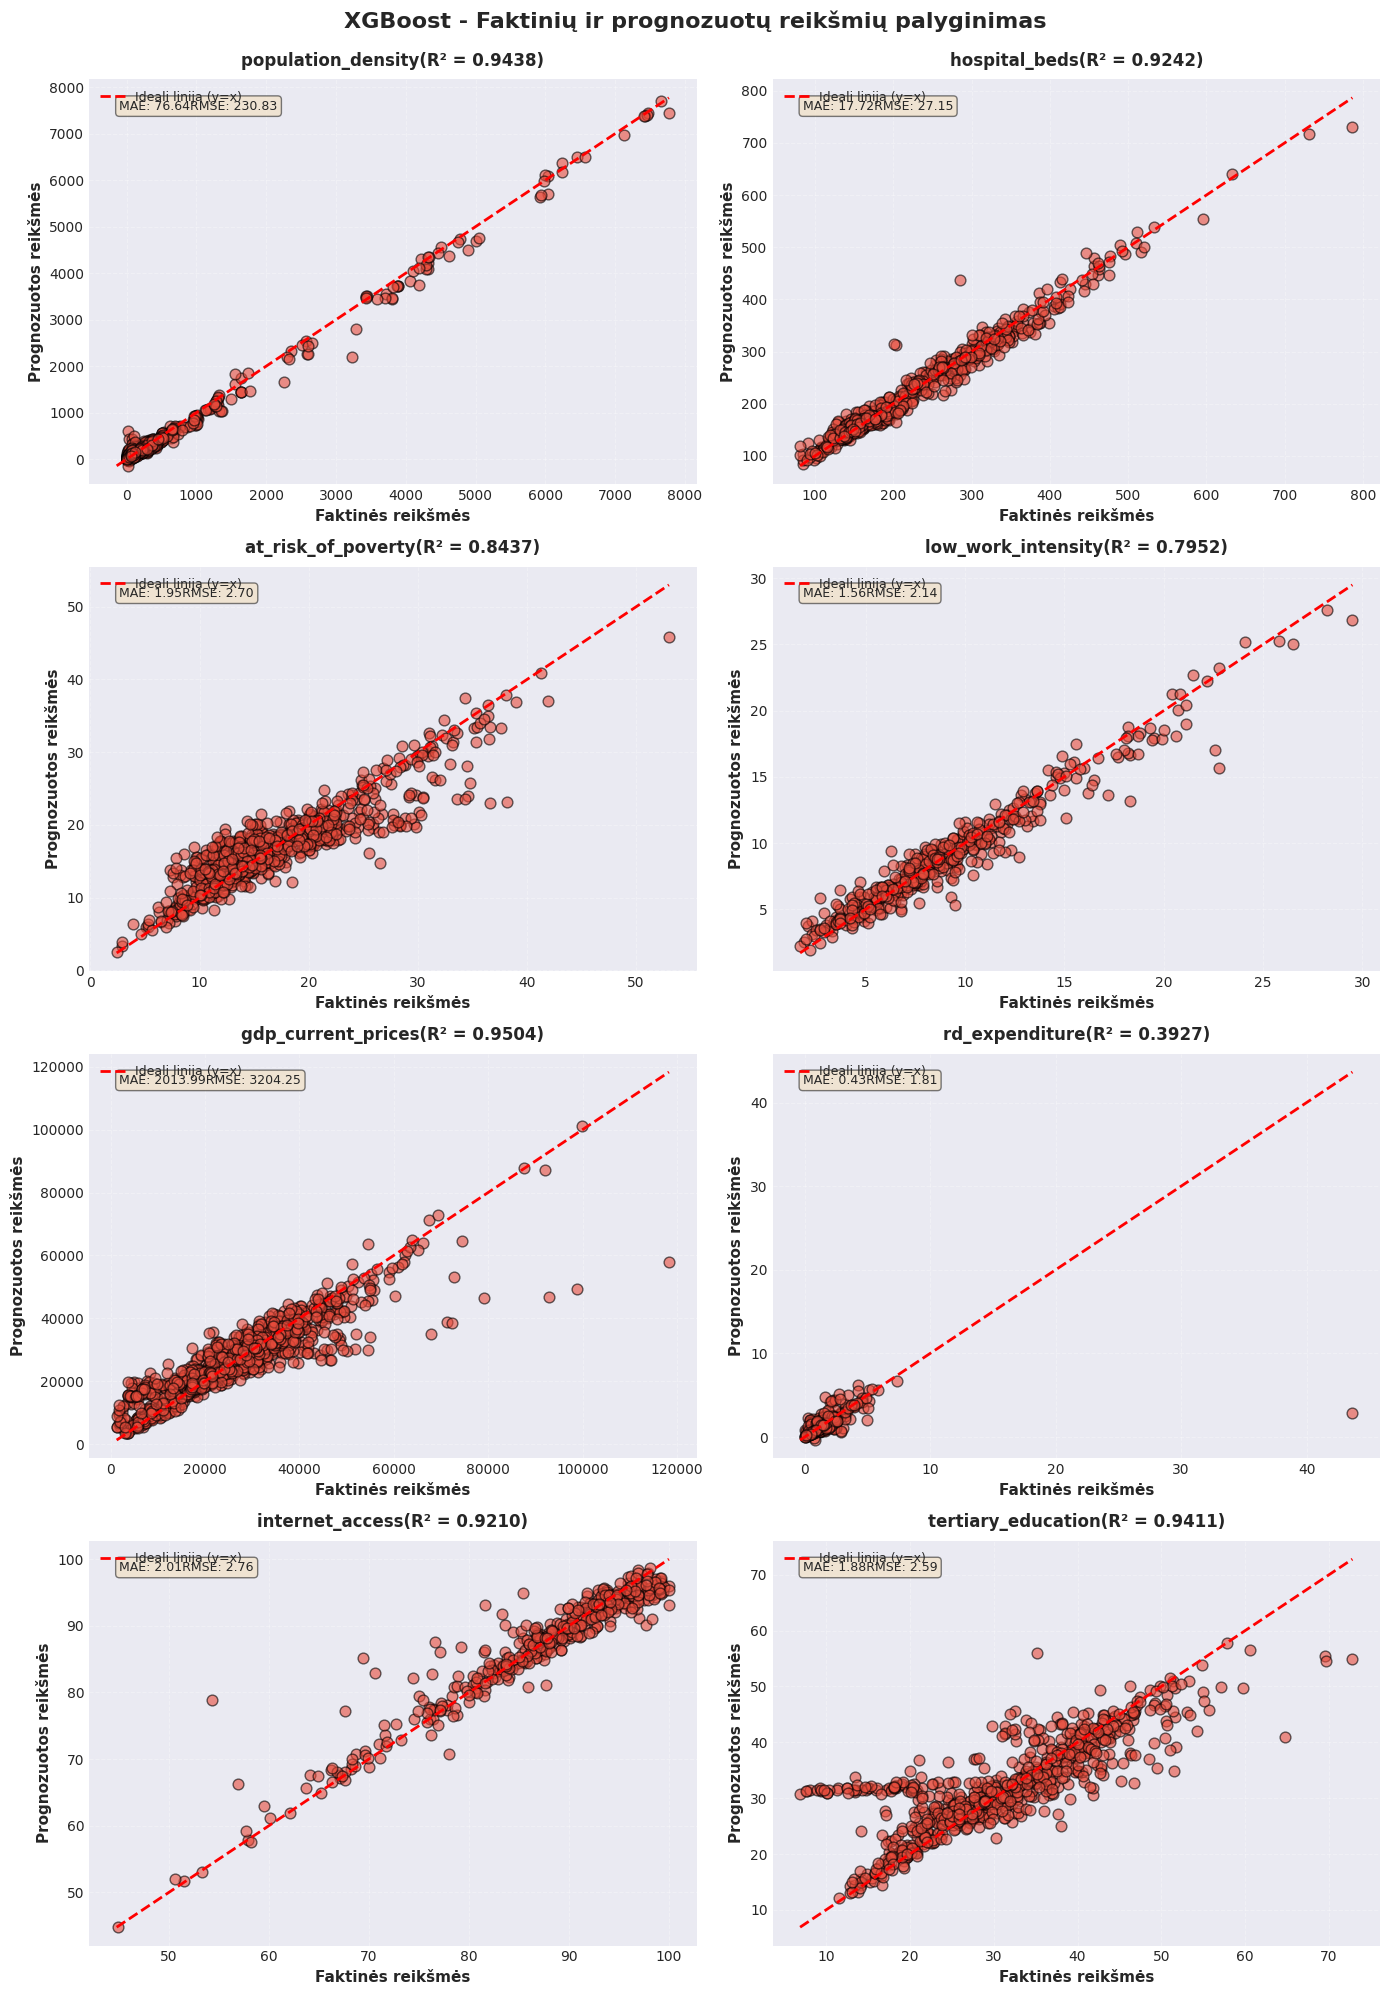


IŠVADA:
Scatter plot grafikai rodo modelio prognozavimo tikslumą:
  • Taškai arčiau raudonos linijos (y=x) = geresnis prognozavimas
  • R² artimas 1.0 = labai tikslus modelis
  • Taškai išsisklaidę = modelis turi sunkumų prognozuojant


In [17]:
# ============================================================================
# FAKTINIŲ IR PROGNOZUOTŲ REIKŠMIŲ PALYGINIMAS (XGBOOST)
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np

print("=" * 100)
print("FAKTINIŲ IR PROGNOZUOTŲ REIKŠMIŲ PALYGINIMAS - XGBOOST")
print("=" * 100)
print()

# Gauname predictions iš modelio (DRY principas - logika modelio klasėje)
xgb_predictions_data = xgb_imputer.get_test_predictions(df)

# Vizualizuojame rezultatus
if len(xgb_predictions_data) > 0:
    n_indicators = len(xgb_predictions_data)
    n_cols = 2
    n_rows = (n_indicators + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
    axes = axes.flatten() if n_indicators > 1 else [axes]
    
    for idx, (indicator, data) in enumerate(xgb_predictions_data.items()):
        ax = axes[idx]
        y_test = data["y_test"]
        y_pred = data["y_pred"]
        r2 = data["r2"]
        
        # Scatter plot
        ax.scatter(y_test, y_pred, alpha=0.6, edgecolors="k", s=60, color="#e74c3c")
        
        # Ideali linija (y = x)
        min_val = min(y_test.min(), y_pred.min())
        max_val = max(y_test.max(), y_pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], "r--", lw=2, label="Ideali linija (y=x)")
        
        # Formatavimas
        ax.set_xlabel("Faktinės reikšmės", fontsize=11, fontweight="bold")
        ax.set_ylabel("Prognozuotos reikšmės", fontsize=11, fontweight="bold")
        ax.set_title(f"{indicator}(R² = {r2:.4f})", fontsize=12, fontweight="bold", pad=10)
        ax.legend(loc="upper left", fontsize=9)
        ax.grid(True, alpha=0.3, linestyle="--")
        
        # Pridedame tekstą su statistika
        mae = data.get("mae", np.mean(np.abs(y_test - y_pred)))  # Išsaugota arba perskaičiuota
        rmse = data.get("rmse", np.sqrt(np.mean((y_test - y_pred)**2)))  # Išsaugota arba perskaičiuota
        ax.text(0.05, 0.95, f"MAE: {mae:.2f}RMSE: {rmse:.2f}",
                transform=ax.transAxes, fontsize=9, verticalalignment="top",
                bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
    
    # Pašaliname tuščius subplot'us jei yra
    for idx in range(len(xgb_predictions_data), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.suptitle("XGBoost - Faktinių ir prognozuotų reikšmių palyginimas",
                 fontsize=16, fontweight="bold", y=0.995)
    plt.tight_layout()
    plt.show()
else:
    print("Nerasta rodiklių, kuriems būtų galima sukurti scatter plots.")

print()
print("=" * 100)
print("IŠVADA:")
print("=" * 100)
print("Scatter plot grafikai rodo modelio prognozavimo tikslumą:")
print("  • Taškai arčiau raudonos linijos (y=x) = geresnis prognozavimas")
print("  • R² artimas 1.0 = labai tikslus modelis")
print("  • Taškai išsisklaidę = modelis turi sunkumų prognozuojant")
print("=" * 100)

### 5.3 Požymių svarbos analizė

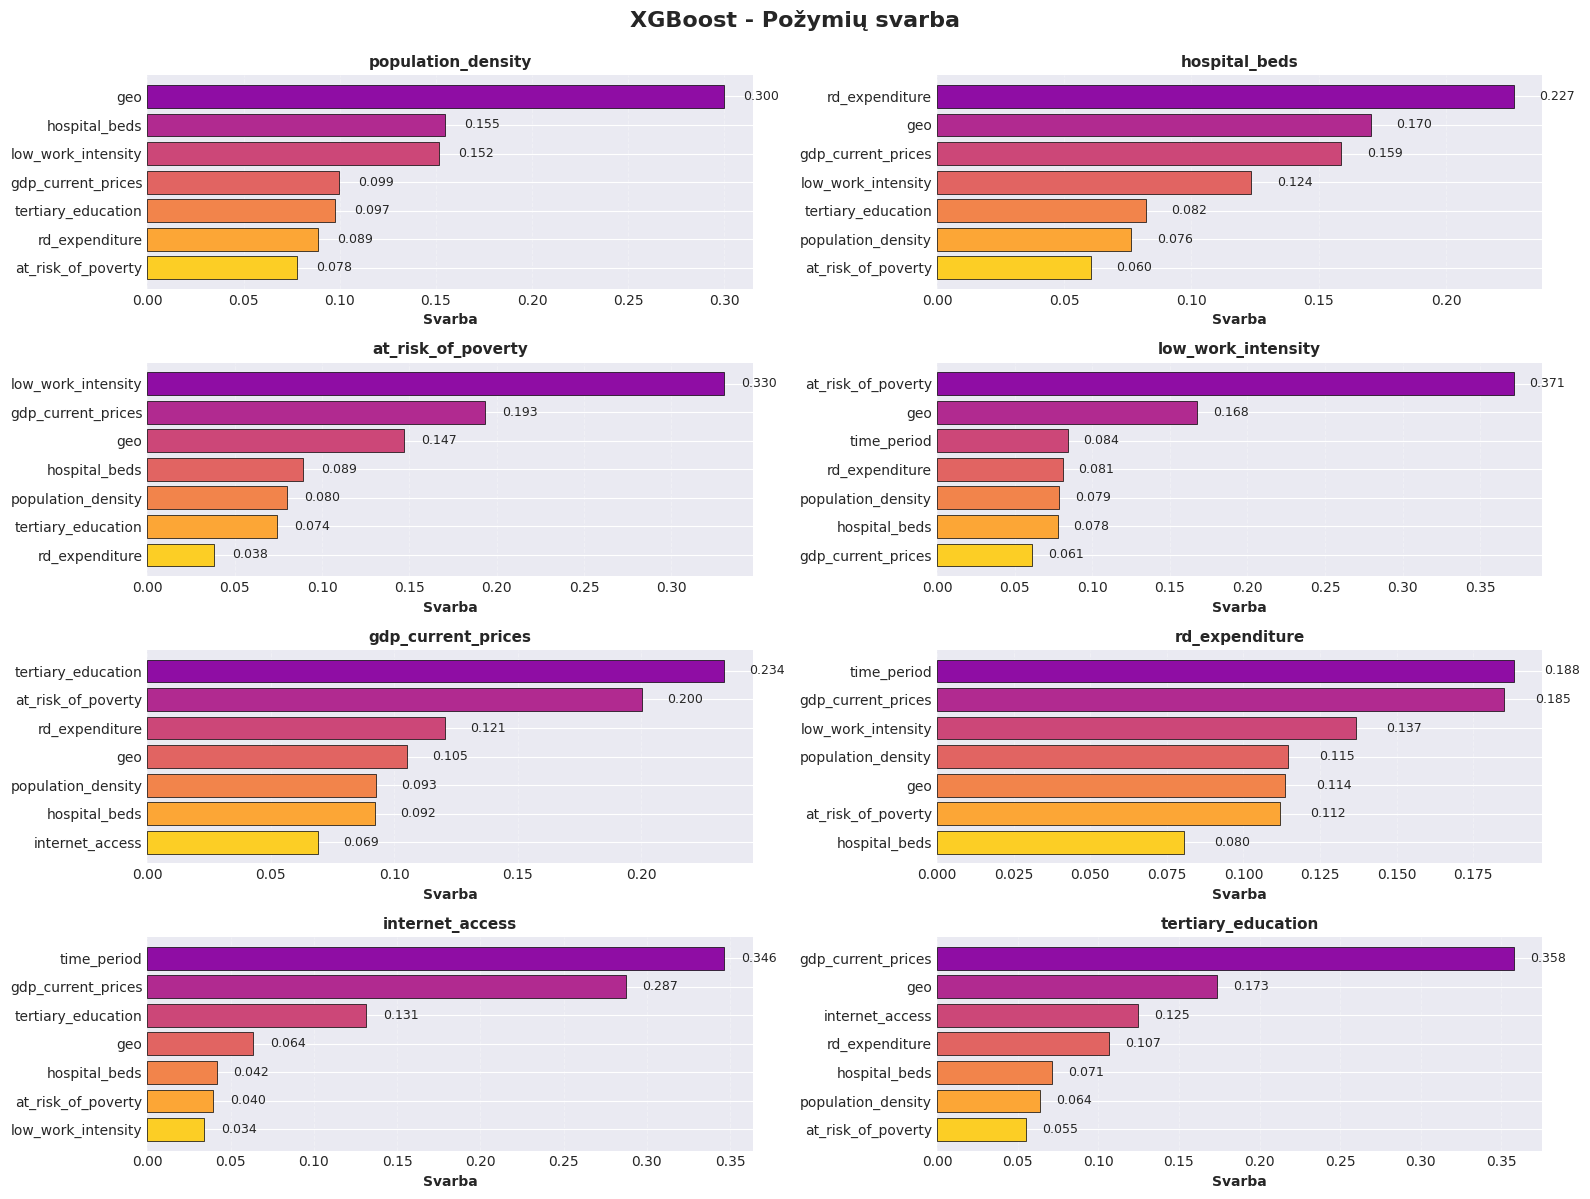

Išanalizuota 8 rodiklių


In [18]:
# ============================================================================
# XGBOOST - POŽYMIŲ SVARBOS VIZUALIZACIJA
# ============================================================================

xgb_feature_importance = xgb_imputer.get_feature_importance()

indicators_xgb = [k for k in xgb_feature_importance.keys() if k not in ['geo', 'time_period']]

n_cols = 2
n_rows = (len(indicators_xgb) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))
axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes

for idx, indicator in enumerate(indicators_xgb):
    ax = axes[idx]
    importance_dict = xgb_feature_importance[indicator]

    imp_df = pd.DataFrame(
        list(importance_dict.items()),
        columns=['Požymis', 'Svarba']
    ).sort_values('Svarba', ascending=False).head(7)

    colors = plt.cm.plasma(np.linspace(0.3, 0.9, len(imp_df)))
    bars = ax.barh(range(len(imp_df)), imp_df['Svarba'], color=colors, edgecolor='black', linewidth=0.5)

    ax.set_yticks(range(len(imp_df)))
    ax.set_yticklabels(imp_df['Požymis'])
    ax.set_xlabel('Svarba', fontsize=10, fontweight='bold')
    ax.set_title(indicator, fontsize=11, fontweight='bold')
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.invert_yaxis()

    for i, (bar, val) in enumerate(zip(bars, imp_df['Svarba'])):
        ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=9)

for idx in range(len(indicators_xgb), len(axes)):
    axes[idx].axis('off')

plt.suptitle('XGBoost - Požymių svarba', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print(f"Išanalizuota {len(indicators_xgb)} rodiklių")

### 5.4 R² reikšmių vizualizacija

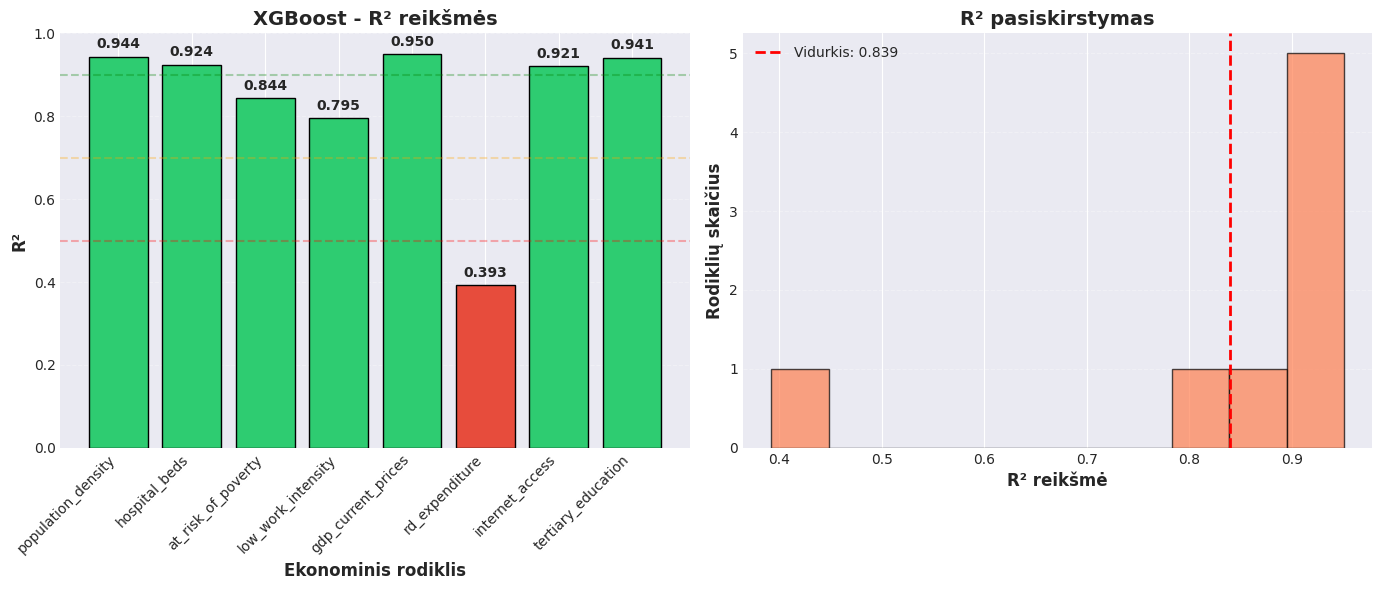

In [19]:
# ============================================================================
# XGBOOST - R² REIKŠMIŲ VIZUALIZACIJA
# ============================================================================

valid_df_xgb = xgb_metrics_df.dropna(subset=['R²']).copy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Stulpelinė diagrama
colors_xgb = valid_df_xgb['R²'].apply(lambda x: '#2ecc71' if x >= 0.7 else '#f39c12' if x >= 0.5 else '#e74c3c')
bars_xgb = ax1.bar(range(len(valid_df_xgb)), valid_df_xgb['R²'], color=colors_xgb, edgecolor='black', linewidth=1)

ax1.set_xlabel('Ekonominis rodiklis', fontsize=12, fontweight='bold')
ax1.set_ylabel('R²', fontsize=12, fontweight='bold')
ax1.set_title('XGBoost - R² reikšmės', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(valid_df_xgb)))
ax1.set_xticklabels(valid_df_xgb['Rodiklis'], rotation=45, ha='right')
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.axhline(y=0.9, color='green', linestyle='--', alpha=0.3)
ax1.axhline(y=0.7, color='orange', linestyle='--', alpha=0.3)
ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.3)

for bar, val in zip(bars_xgb, valid_df_xgb['R²']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{val:.3f}', ha='center', fontsize=10, fontweight='bold')

# Histograma
ax2.hist(valid_df_xgb['R²'], bins=10, color='coral', edgecolor='black', alpha=0.7)
ax2.set_xlabel('R² reikšmė', fontsize=12, fontweight='bold')
ax2.set_ylabel('Rodiklių skaičius', fontsize=12, fontweight='bold')
ax2.set_title('R² pasiskirstymas', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.axvline(x=valid_df_xgb['R²'].mean(), color='red', linestyle='--', linewidth=2,
            label=f'Vidurkis: {valid_df_xgb["R²"].mean():.3f}')
ax2.legend()

plt.tight_layout()
plt.show()

### 5.5 Išvados

In [20]:
# ============================================================================
# XGBOOST MODELIO IŠVADOS
# ============================================================================

print("=" * 90)
print("XGBOOST MODELIO IŠVADOS")
print("=" * 90)

valid_r2_xgb = xgb_metrics_df['R²'].dropna()

r2_excellent_xgb = (valid_r2_xgb >= 0.9).sum()
r2_good_xgb = ((valid_r2_xgb >= 0.7) & (valid_r2_xgb < 0.9)).sum()
r2_medium_xgb = ((valid_r2_xgb >= 0.5) & (valid_r2_xgb < 0.7)).sum()
r2_poor_xgb = (valid_r2_xgb < 0.5).sum()

print(f"\n1. MODELIO EFEKTYVUMAS:")
print(f"   - Vidutinis R²: {valid_r2_xgb.mean():.4f}")
print(f"   - Mediana: {valid_r2_xgb.median():.4f}")
print(f"   - Standartinis nuokrypis: {valid_r2_xgb.std():.4f}")

print(f"\n2. R² PASISKIRSTYMAS:")
print(f"   - Puikus (R² ≥ 0.9): {r2_excellent_xgb} rodikliai")
print(f"   - Geras (0.7 ≤ R² < 0.9): {r2_good_xgb} rodikliai")
print(f"   - Vidutinis (0.5 ≤ R² < 0.7): {r2_medium_xgb} rodikliai")
print(f"   - Silpnas (R² < 0.5): {r2_poor_xgb} rodikliai")

best_idx_xgb = xgb_metrics_df['R²'].idxmax()
worst_idx_xgb = xgb_metrics_df['R²'].idxmin()

print(f"\n3. EKSTREMALŪS ATVEJAI:")
print(f"   Geriausias: {xgb_metrics_df.loc[best_idx_xgb, 'Rodiklis']} (R²={xgb_metrics_df.loc[best_idx_xgb, 'R²']:.4f})")
print(f"   Blogiausias: {xgb_metrics_df.loc[worst_idx_xgb, 'Rodiklis']} (R²={xgb_metrics_df.loc[worst_idx_xgb, 'R²']:.4f})")

print(f"\n4. BENDROJI IŠVADA:")
if valid_r2_xgb.mean() >= 0.7:
    print(f"   ✓ XGBoost pasiekia gerą tikslumą (vid. R² ≥ 0.7)")
elif valid_r2_xgb.mean() >= 0.5:
    print(f"   ≈ XGBoost pasiekia vidutinį tikslumą (vid. R² ≥ 0.5)")
else:
    print(f"   ✗ XGBoost pasiekia silpną tikslumą (vid. R² < 0.5)")

print(f"\n   • Užpildyta {len(valid_r2_xgb)}/{len(xgb_metrics_df)} ekonominių rodiklių")
print(f"   • Naudoti Flask aplikacijos parametrai")
print(f"\n{'=' * 90}")

XGBOOST MODELIO IŠVADOS

1. MODELIO EFEKTYVUMAS:
   - Vidutinis R²: 0.8390
   - Mediana: 0.9226
   - Standartinis nuokrypis: 0.1886

2. R² PASISKIRSTYMAS:
   - Puikus (R² ≥ 0.9): 5 rodikliai
   - Geras (0.7 ≤ R² < 0.9): 2 rodikliai
   - Vidutinis (0.5 ≤ R² < 0.7): 0 rodikliai
   - Silpnas (R² < 0.5): 1 rodikliai

3. EKSTREMALŪS ATVEJAI:
   Geriausias: gdp_current_prices (R²=0.9504)
   Blogiausias: rd_expenditure (R²=0.3927)

4. BENDROJI IŠVADA:
   ✓ XGBoost pasiekia gerą tikslumą (vid. R² ≥ 0.7)

   • Užpildyta 8/8 ekonominių rodiklių
   • Naudoti Flask aplikacijos parametrai



## 6. Modelių palyginimas

Šiame skyriuje lyginame Random Forest ir XGBoost modelių našumą užpildant trūkstamas ekonominių rodiklių reikšmes. Palyginimas atliekamas pagal keturias pagrindines metrikus:

- **R² (Determinacijos koeficientas)** - parodo, kiek procentų duomenų variacijos paaiškina modelis
- **RMSE (Root Mean Squared Error)** - vidutinė kvadratinė paklaida
- **MAE (Mean Absolute Error)** - vidutinė absoliutinė paklaida  
- **MAPE (Mean Absolute Percentage Error)** - vidutinė absoliutinė procentinė paklaida

Kiekviena metrika vizualizuojama stulpelinėje diagramoje, kurioje palyginti visi 8 ekonominiai rodikliai tarp abiejų modelių.

### 6.1 R² (Determinacijos koeficiento) palyginimas

R² (DETERMINACIJOS KOEFICIENTO) PALYGINIMAS



,Rodiklis,Random Forest,XGBoost,Skirtumas,Geresnis
0,population_density,0.8819,0.9438,0.0619,XGBoost
1,hospital_beds,0.8890,0.9242,0.0352,XGBoost
2,at_risk_of_poverty,0.8100,0.8437,0.0337,XGBoost
3,low_work_intensity,0.7804,0.7952,0.0149,XGBoost
4,gdp_current_prices,0.9181,0.9504,0.0323,XGBoost
5,rd_expenditure,0.2926,0.3927,0.1001,XGBoost
6,internet_access,0.8978,0.9210,0.0232,XGBoost
7,tertiary_education,0.8936,0.9411,0.0475,XGBoost


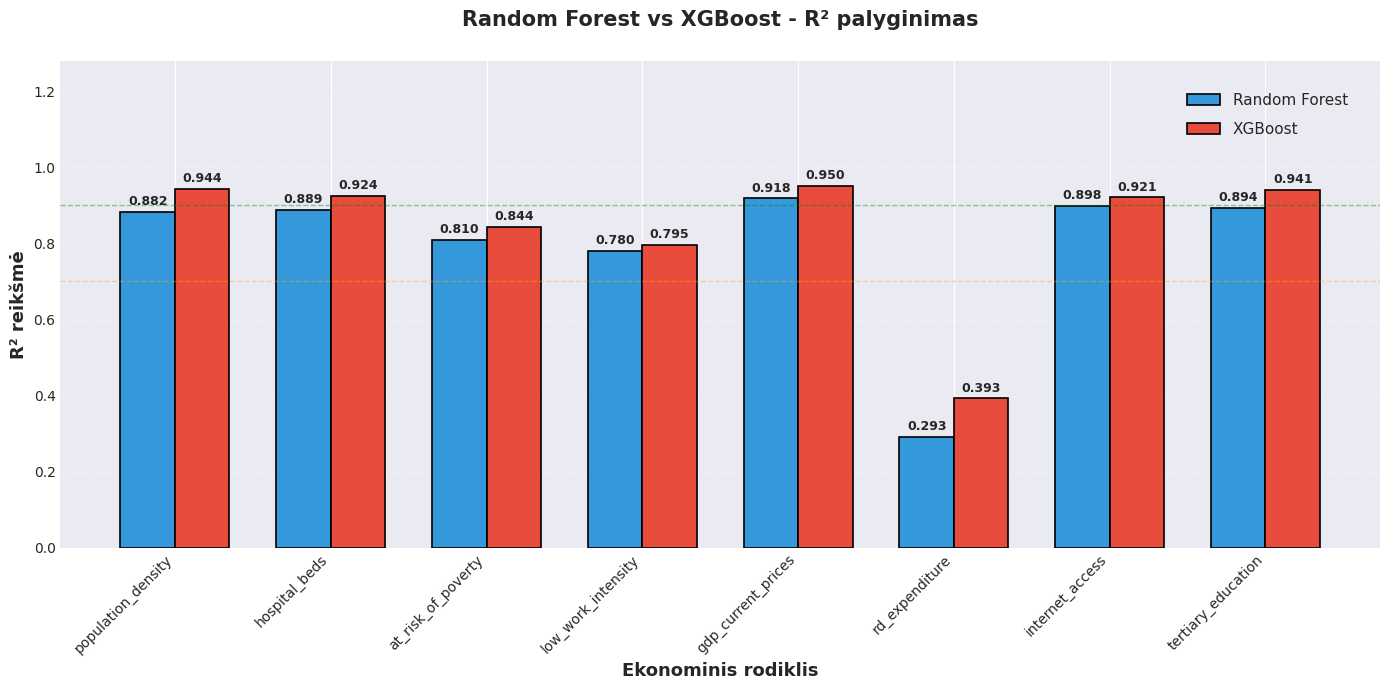


STATISTINĖ SUVESTINĖ:

Random Forest:
  - Vidutinis R²: 0.7954
  - Geriausias: gdp_current_prices (R²=0.9181)
  - Blogiausias: rd_expenditure (R²=0.2926)

XGBoost:
  - Vidutinis R²: 0.8390
  - Geriausias: gdp_current_prices (R²=0.9504)
  - Blogiausias: rd_expenditure (R²=0.3927)

Palyginimas:
  - XGBoost geresnis: 8/8 rodiklių
  - Random Forest geresnis: 0/8 rodiklių
  - Vienodi: 0/8 rodiklių
  - Vidutinis skirtumas: 0.0436 (XGBoost naudai)


In [21]:
# ========================================================================
# R² PALYGINIMAS – RANDOM FOREST vs XGBOOST (pilnas kodas)
# ========================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# ------------------------------------------------------------
# Pradiniai duomenys:
# Tikimasi, kad turite du DataFrame: rf_metrics_df ir xgb_metrics_df,
# kuriuose yra stulpeliai: 'Rodiklis' ir 'R²'
# pvz.:
# rf_metrics_df = pd.DataFrame({'Rodiklis': [...], 'R²': [...]})
# xgb_metrics_df = pd.DataFrame({'Rodiklis': [...], 'R²': [...]})
# ------------------------------------------------------------

# 1) Sukuriame palyginimo DataFrame
r2_comparison = pd.DataFrame({
    'Rodiklis': rf_metrics_df['Rodiklis'],
    'Random Forest': rf_metrics_df['R²'],
    'XGBoost': xgb_metrics_df['R²']
})

# 2) Apskaičiuojame skirtumus ir „geresnį“ modelį
r2_comparison['Skirtumas'] = r2_comparison['XGBoost'] - r2_comparison['Random Forest']
r2_comparison['Geresnis'] = r2_comparison['Skirtumas'].apply(
    lambda x: 'XGBoost' if x > 0 else 'Random Forest' if x < 0 else 'Vienodi'
)

print("=" * 100)
print("R² (DETERMINACIJOS KOEFICIENTO) PALYGINIMAS")
print("=" * 100)
print()

# 3) Rodyti lentelę su gradientu
display(
    r2_comparison.style.format({
        'Random Forest': '{:.4f}',
        'XGBoost': '{:.4f}',
        'Skirtumas': '{:.4f}'
    }).background_gradient(subset=['Random Forest', 'XGBoost'], cmap='RdYlGn', vmin=0, vmax=1)
)

print()
print("=" * 100)

# 4) Grafiko braižymas su legenda viršuje dešinėje ir papildomu tarpu
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(r2_comparison))
width = 0.35

bars1 = ax.bar(
    x - width/2, r2_comparison['Random Forest'], width,
    label='Random Forest', color='#3498db', edgecolor='black', linewidth=1.2
)
bars2 = ax.bar(
    x + width/2, r2_comparison['XGBoost'], width,
    label='XGBoost', color='#e74c3c', edgecolor='black', linewidth=1.2
)

# Reikšmės ant stulpelių
for bars in (bars1, bars2):
    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2., h + 0.01,
            f'{h:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold'
        )

ax.set_xlabel('Ekonominis rodiklis', fontsize=13, fontweight='bold')
ax.set_ylabel('R² reikšmė', fontsize=13, fontweight='bold')
ax.set_title('Random Forest vs XGBoost - R² palyginimas', fontsize=15, fontweight='bold', pad=25)
ax.set_xticks(x)
ax.set_xticklabels(r2_comparison['Rodiklis'], rotation=45, ha='right')

# ---- LEGENDA VIRŠUJE DEŠINĖJE + PAPILDOMAS TARPAS ----
# prisitaikanti viršutinė riba, kad legenda netrukdytų stulpeliams
max_val = float(max(r2_comparison['Random Forest'].max(), r2_comparison['XGBoost'].max()))
upper = 1.28 if max_val <= 1.0 else max_val * 1.35
ax.set_ylim(0, upper)

# šiek tiek papildomo vertikalaus tarpo viršuje
ax.margins(y=0.4)

# pati legenda – viršus/dešinė, su papildomu vidiniu tarpu
ax.legend(
    fontsize=11, loc='upper right',
    frameon=False,            # be rėmelio (švariau)
    borderpad=1.6,            # vidinis tarpas legendos dėžutėje
    labelspacing=0.9,         # tarpai tarp legendos eilučių
    handlelength=2.2,         # šiek tiek ilgesnės žymos
)

# Pagalbinės linijos
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0.9, color='green', linestyle='--', alpha=0.4, linewidth=1)
ax.axhline(y=0.7, color='orange', linestyle='--', alpha=0.4, linewidth=1)

plt.tight_layout()
plt.show()

# 5) Statistinė suvestinė
print()
print("=" * 100)
print("STATISTINĖ SUVESTINĖ:")
print("=" * 100)
print(f"\nRandom Forest:")
print(f"  - Vidutinis R²: {r2_comparison['Random Forest'].mean():.4f}")
print(f"  - Geriausias: {r2_comparison.loc[r2_comparison['Random Forest'].idxmax(), 'Rodiklis']} "
      f"(R²={r2_comparison['Random Forest'].max():.4f})")
print(f"  - Blogiausias: {r2_comparison.loc[r2_comparison['Random Forest'].idxmin(), 'Rodiklis']} "
      f"(R²={r2_comparison['Random Forest'].min():.4f})")

print(f"\nXGBoost:")
print(f"  - Vidutinis R²: {r2_comparison['XGBoost'].mean():.4f}")
print(f"  - Geriausias: {r2_comparison.loc[r2_comparison['XGBoost'].idxmax(), 'Rodiklis']} "
      f"(R²={r2_comparison['XGBoost'].max():.4f})")
print(f"  - Blogiausias: {r2_comparison.loc[r2_comparison['XGBoost'].idxmin(), 'Rodiklis']} "
      f"(R²={r2_comparison['XGBoost'].min():.4f})")

print(f"\nPalyginimas:")
better_xgb = int((r2_comparison['Skirtumas'] > 0).sum())
better_rf = int((r2_comparison['Skirtumas'] < 0).sum())
equal = int((r2_comparison['Skirtumas'] == 0).sum())

print(f"  - XGBoost geresnis: {better_xgb}/{len(r2_comparison)} rodiklių")
print(f"  - Random Forest geresnis: {better_rf}/{len(r2_comparison)} rodiklių")
print(f"  - Vienodi: {equal}/{len(r2_comparison)} rodiklių")
mean_diff = r2_comparison['Skirtumas'].mean()
print(f"  - Vidutinis skirtumas: {mean_diff:.4f} "
      f"({'XGBoost' if mean_diff > 0 else 'Random Forest'} naudai)")

print("=" * 100)


### 6.2 RMSE (Root Mean Squared Error) palyginimas

RMSE (ROOT MEAN SQUARED ERROR) PALYGINIMAS



,Rodiklis,Random Forest,XGBoost,Skirtumas,Geresnis
0,population_density,334.65,230.83,103.82,XGBoost
1,hospital_beds,32.85,27.15,5.70,XGBoost
2,at_risk_of_poverty,2.97,2.70,0.28,XGBoost
3,low_work_intensity,2.21,2.14,0.08,XGBoost
4,gdp_current_prices,4118.23,3204.25,913.98,XGBoost
5,rd_expenditure,1.95,1.81,0.14,XGBoost
6,internet_access,3.14,2.76,0.38,XGBoost
7,tertiary_education,3.48,2.59,0.89,XGBoost


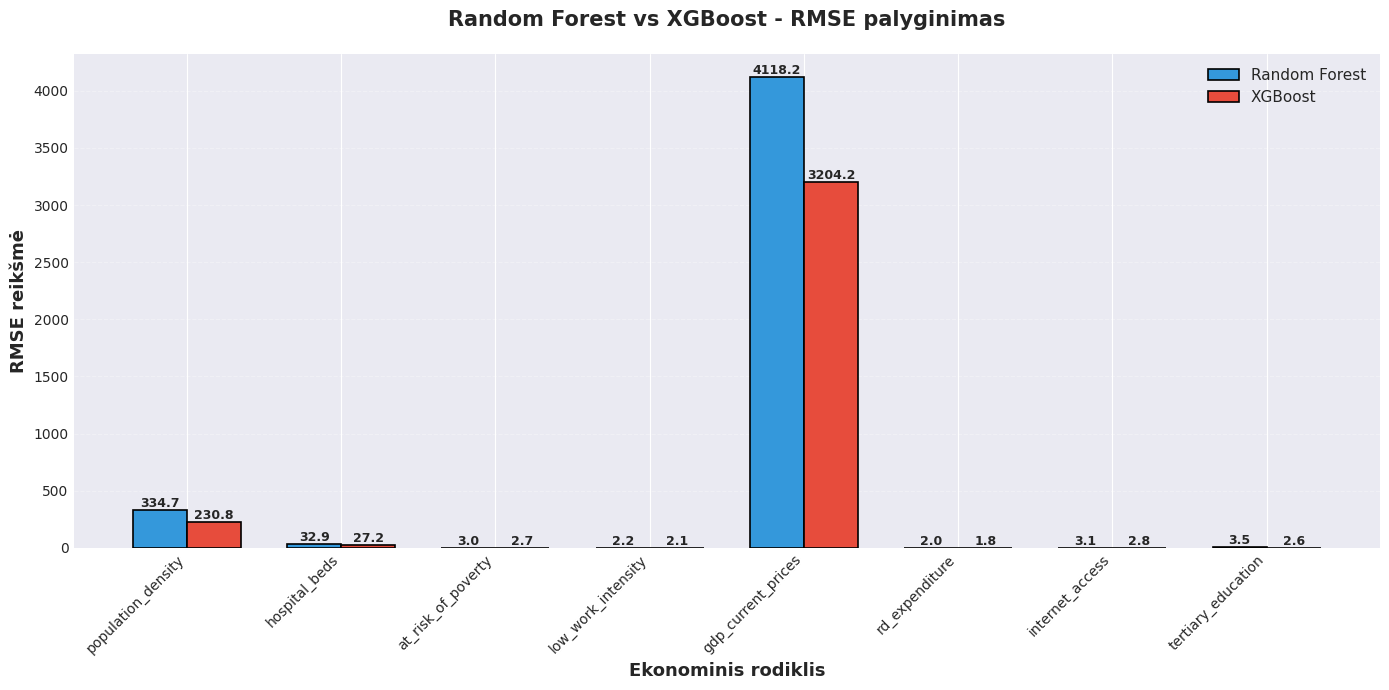


STATISTINĖ SUVESTINĖ:

Random Forest:
  - Vidutinis RMSE: 562.44
  - Mažiausias: rd_expenditure (RMSE=1.95)
  - Didžiausias: gdp_current_prices (RMSE=4118.23)

XGBoost:
  - Vidutinis RMSE: 434.28
  - Mažiausias: rd_expenditure (RMSE=1.81)
  - Didžiausias: gdp_current_prices (RMSE=3204.25)

Palyginimas:
  - XGBoost geresnis (mažesnis RMSE): 8/8 rodiklių
  - Random Forest geresnis: 0/8 rodiklių
  - Vienodi: 0/8 rodiklių
  - Vidutinis skirtumas: 128.16 (XGBoost naudai)


In [22]:
# ============================================================================
# RMSE PALYGINIMAS - RANDOM FOREST vs XGBOOST
# ============================================================================

# Sukuriame palyginimo DataFrame
rmse_comparison = pd.DataFrame({
    'Rodiklis': rf_metrics_df['Rodiklis'],
    'Random Forest': rf_metrics_df['RMSE'],
    'XGBoost': xgb_metrics_df['RMSE']
})

# Apskaičiuojame skirtumą (mažesnis = geresnis)
rmse_comparison['Skirtumas'] = rmse_comparison['Random Forest'] - rmse_comparison['XGBoost']
rmse_comparison['Geresnis'] = rmse_comparison['Skirtumas'].apply(
    lambda x: 'XGBoost' if x > 0 else 'Random Forest' if x < 0 else 'Vienodi'
)

print("=" * 100)
print("RMSE (ROOT MEAN SQUARED ERROR) PALYGINIMAS")
print("=" * 100)
print()

# Rodyti lentelę
display(rmse_comparison.style.format({
    'Random Forest': '{:.2f}',
    'XGBoost': '{:.2f}',
    'Skirtumas': '{:.2f}'
}).background_gradient(subset=['Random Forest', 'XGBoost'], cmap='RdYlGn_r'))

print()
print("=" * 100)

# Grafiko braižymas
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(rmse_comparison))
width = 0.35

bars1 = ax.bar(x - width/2, rmse_comparison['Random Forest'], width, 
               label='Random Forest', color='#3498db', edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x + width/2, rmse_comparison['XGBoost'], width,
               label='XGBoost', color='#e74c3c', edgecolor='black', linewidth=1.2)

# Pridedame reikšmes ant stulpelių
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Ekonominis rodiklis', fontsize=13, fontweight='bold')
ax.set_ylabel('RMSE reikšmė', fontsize=13, fontweight='bold')
ax.set_title('Random Forest vs XGBoost - RMSE palyginimas', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(rmse_comparison['Rodiklis'], rotation=45, ha='right')
ax.legend(fontsize=11, loc='upper right')
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Statistika
print()
print("=" * 100)
print("STATISTINĖ SUVESTINĖ:")
print("=" * 100)
print(f"\nRandom Forest:")
print(f"  - Vidutinis RMSE: {rmse_comparison['Random Forest'].mean():.2f}")
print(f"  - Mažiausias: {rmse_comparison.loc[rmse_comparison['Random Forest'].idxmin(), 'Rodiklis']} "
      f"(RMSE={rmse_comparison['Random Forest'].min():.2f})")
print(f"  - Didžiausias: {rmse_comparison.loc[rmse_comparison['Random Forest'].idxmax(), 'Rodiklis']} "
      f"(RMSE={rmse_comparison['Random Forest'].max():.2f})")

print(f"\nXGBoost:")
print(f"  - Vidutinis RMSE: {rmse_comparison['XGBoost'].mean():.2f}")
print(f"  - Mažiausias: {rmse_comparison.loc[rmse_comparison['XGBoost'].idxmin(), 'Rodiklis']} "
      f"(RMSE={rmse_comparison['XGBoost'].min():.2f})")
print(f"  - Didžiausias: {rmse_comparison.loc[rmse_comparison['XGBoost'].idxmax(), 'Rodiklis']} "
      f"(RMSE={rmse_comparison['XGBoost'].max():.2f})")

print(f"\nPalyginimas:")
better_xgb = (rmse_comparison['Skirtumas'] > 0).sum()
better_rf = (rmse_comparison['Skirtumas'] < 0).sum()
equal = (rmse_comparison['Skirtumas'] == 0).sum()

print(f"  - XGBoost geresnis (mažesnis RMSE): {better_xgb}/{len(rmse_comparison)} rodiklių")
print(f"  - Random Forest geresnis: {better_rf}/{len(rmse_comparison)} rodiklių")
print(f"  - Vienodi: {equal}/{len(rmse_comparison)} rodiklių")
print(f"  - Vidutinis skirtumas: {rmse_comparison['Skirtumas'].mean():.2f} "
      f"({'XGBoost' if rmse_comparison['Skirtumas'].mean() > 0 else 'Random Forest'} naudai)")

print("=" * 100)

### 6.5 Bendra modelių palyginimo analizė ir išvados

### 6.4 MAPE (Mean Absolute Percentage Error) palyginimas

MAPE (MEAN ABSOLUTE PERCENTAGE ERROR) PALYGINIMAS



,Rodiklis,Random Forest,XGBoost,Skirtumas,Geresnis
0,population_density,122.81%,94.86%,27.95%,XGBoost
1,hospital_beds,9.08%,8.32%,0.76%,XGBoost
2,at_risk_of_poverty,13.68%,12.76%,0.92%,XGBoost
3,low_work_intensity,22.07%,20.47%,1.60%,XGBoost
4,gdp_current_prices,11.13%,9.84%,1.28%,XGBoost
5,rd_expenditure,0.00%,0.00%,0.00%,Vienodi
6,internet_access,2.86%,2.43%,0.43%,XGBoost
7,tertiary_education,8.35%,6.97%,1.38%,XGBoost


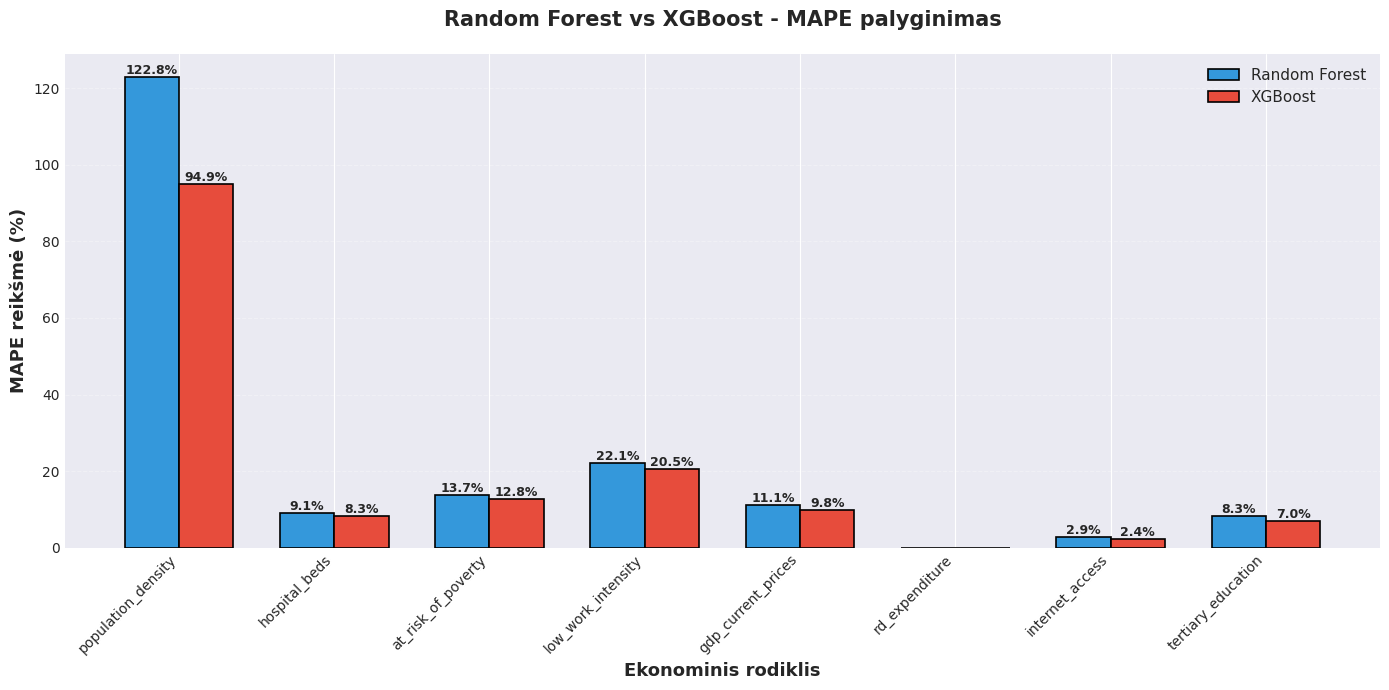


STATISTINĖ SUVESTINĖ:

Random Forest:
  - Vidutinis MAPE: 23.75%
  - Vidutinis MAPE (be nulių): 27.14%
  - Mažiausias: internet_access (MAPE=2.86%)
  - Didžiausias: population_density (MAPE=122.81%)

XGBoost:
  - Vidutinis MAPE: 19.46%
  - Vidutinis MAPE (be nulių): 22.23%
  - Mažiausias: internet_access (MAPE=2.43%)
  - Didžiausias: population_density (MAPE=94.86%)

Palyginimas:
  - XGBoost geresnis (mažesnis MAPE): 7/8 rodiklių
  - Random Forest geresnis: 0/8 rodiklių
  - Vienodi: 1/8 rodiklių
  - Vidutinis skirtumas: 4.29% (XGBoost naudai)


In [23]:
# ============================================================================
# MAPE PALYGINIMAS - RANDOM FOREST vs XGBOOST
# ============================================================================

# Sukuriame palyginimo DataFrame
mape_comparison = pd.DataFrame({
    'Rodiklis': rf_metrics_df['Rodiklis'],
    'Random Forest': rf_metrics_df['MAPE (%)'],
    'XGBoost': xgb_metrics_df['MAPE (%)']
})

# Apskaičiuojame skirtumą (mažesnis = geresnis)
mape_comparison['Skirtumas'] = mape_comparison['Random Forest'] - mape_comparison['XGBoost']
mape_comparison['Geresnis'] = mape_comparison['Skirtumas'].apply(
    lambda x: 'XGBoost' if x > 0 else 'Random Forest' if x < 0 else 'Vienodi'
)

print("=" * 100)
print("MAPE (MEAN ABSOLUTE PERCENTAGE ERROR) PALYGINIMAS")
print("=" * 100)
print()

# Rodyti lentelę
display(mape_comparison.style.format({
    'Random Forest': '{:.2f}%',
    'XGBoost': '{:.2f}%',
    'Skirtumas': '{:.2f}%'
}).background_gradient(subset=['Random Forest', 'XGBoost'], cmap='RdYlGn_r'))

print()
print("=" * 100)

# Grafiko braižymas
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(mape_comparison))
width = 0.35

bars1 = ax.bar(x - width/2, mape_comparison['Random Forest'], width, 
               label='Random Forest', color='#3498db', edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x + width/2, mape_comparison['XGBoost'], width,
               label='XGBoost', color='#e74c3c', edgecolor='black', linewidth=1.2)

# Pridedame reikšmes ant stulpelių
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Rodom tik jei ne nulis
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Ekonominis rodiklis', fontsize=13, fontweight='bold')
ax.set_ylabel('MAPE reikšmė (%)', fontsize=13, fontweight='bold')
ax.set_title('Random Forest vs XGBoost - MAPE palyginimas', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(mape_comparison['Rodiklis'], rotation=45, ha='right')
ax.legend(fontsize=11, loc='upper right')
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Statistika
print()
print("=" * 100)
print("STATISTINĖ SUVESTINĖ:")
print("=" * 100)

# Filtruojame tik ne-nulinius MAPE (nes 0 gali reikšti klaida skaičiavimuose)
rf_mape_nonzero = mape_comparison['Random Forest'][mape_comparison['Random Forest'] > 0]
xgb_mape_nonzero = mape_comparison['XGBoost'][mape_comparison['XGBoost'] > 0]

print(f"\nRandom Forest:")
print(f"  - Vidutinis MAPE: {mape_comparison['Random Forest'].mean():.2f}%")
if len(rf_mape_nonzero) > 0:
    print(f"  - Vidutinis MAPE (be nulių): {rf_mape_nonzero.mean():.2f}%")
    min_idx = mape_comparison[mape_comparison['Random Forest'] == rf_mape_nonzero.min()].index[0]
    print(f"  - Mažiausias: {mape_comparison.loc[min_idx, 'Rodiklis']} "
          f"(MAPE={rf_mape_nonzero.min():.2f}%)")
print(f"  - Didžiausias: {mape_comparison.loc[mape_comparison['Random Forest'].idxmax(), 'Rodiklis']} "
      f"(MAPE={mape_comparison['Random Forest'].max():.2f}%)")

print(f"\nXGBoost:")
print(f"  - Vidutinis MAPE: {mape_comparison['XGBoost'].mean():.2f}%")
if len(xgb_mape_nonzero) > 0:
    print(f"  - Vidutinis MAPE (be nulių): {xgb_mape_nonzero.mean():.2f}%")
    min_idx = mape_comparison[mape_comparison['XGBoost'] == xgb_mape_nonzero.min()].index[0]
    print(f"  - Mažiausias: {mape_comparison.loc[min_idx, 'Rodiklis']} "
          f"(MAPE={xgb_mape_nonzero.min():.2f}%)")
print(f"  - Didžiausias: {mape_comparison.loc[mape_comparison['XGBoost'].idxmax(), 'Rodiklis']} "
      f"(MAPE={mape_comparison['XGBoost'].max():.2f}%)")

print(f"\nPalyginimas:")
better_xgb = (mape_comparison['Skirtumas'] > 0).sum()
better_rf = (mape_comparison['Skirtumas'] < 0).sum()
equal = (mape_comparison['Skirtumas'] == 0).sum()

print(f"  - XGBoost geresnis (mažesnis MAPE): {better_xgb}/{len(mape_comparison)} rodiklių")
print(f"  - Random Forest geresnis: {better_rf}/{len(mape_comparison)} rodiklių")
print(f"  - Vienodi: {equal}/{len(mape_comparison)} rodiklių")
print(f"  - Vidutinis skirtumas: {mape_comparison['Skirtumas'].mean():.2f}% "
      f"({'XGBoost' if mape_comparison['Skirtumas'].mean() > 0 else 'Random Forest'} naudai)")

print("=" * 100)

### 6.3 MAE (Mean Absolute Error) palyginimas

MAE (MEAN ABSOLUTE ERROR) PALYGINIMAS



,Rodiklis,Random Forest,XGBoost,Skirtumas,Geresnis
0,population_density,128.17,76.64,51.52,XGBoost
1,hospital_beds,19.62,17.72,1.90,XGBoost
2,at_risk_of_poverty,2.04,1.95,0.09,XGBoost
3,low_work_intensity,1.65,1.56,0.09,XGBoost
4,gdp_current_prices,2288.12,2013.99,274.12,XGBoost
5,rd_expenditure,0.40,0.43,-0.03,Random Forest
6,internet_access,2.32,2.01,0.32,XGBoost
7,tertiary_education,2.38,1.88,0.50,XGBoost


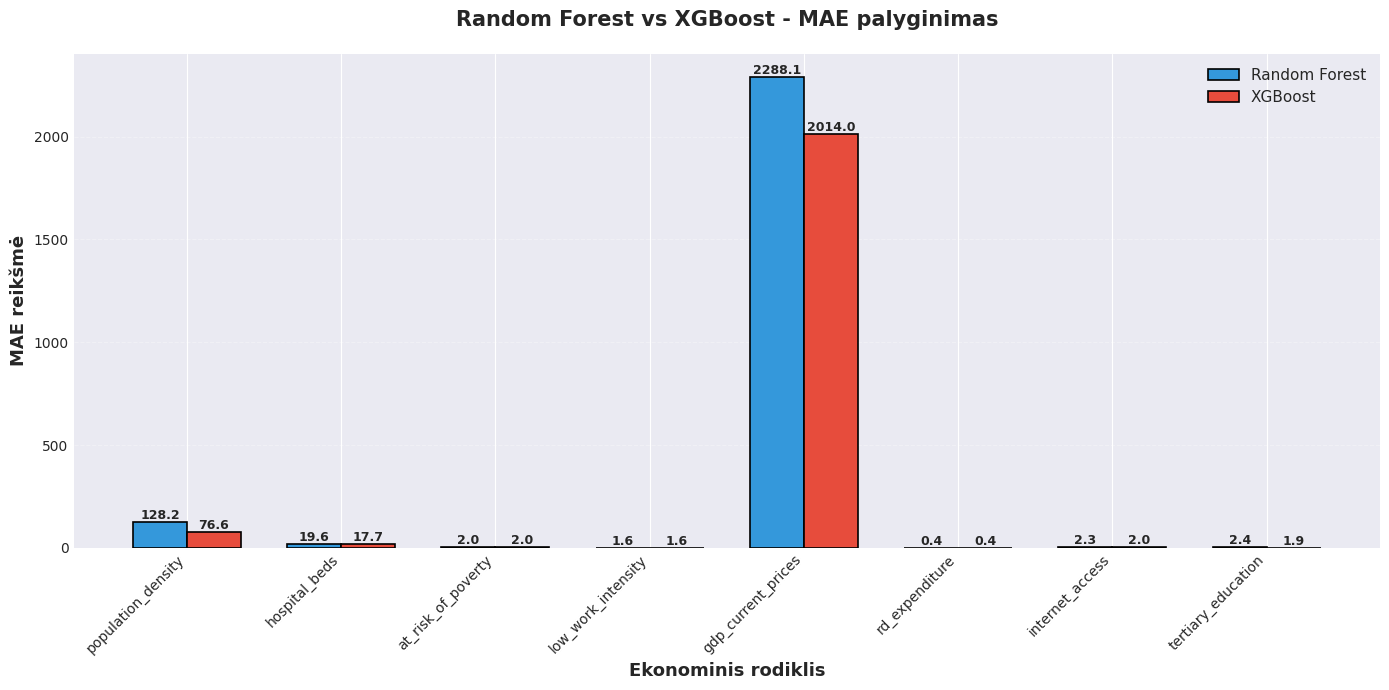


STATISTINĖ SUVESTINĖ:

Random Forest:
  - Vidutinis MAE: 305.59
  - Mažiausias: rd_expenditure (MAE=0.40)
  - Didžiausias: gdp_current_prices (MAE=2288.12)

XGBoost:
  - Vidutinis MAE: 264.52
  - Mažiausias: rd_expenditure (MAE=0.43)
  - Didžiausias: gdp_current_prices (MAE=2013.99)

Palyginimas:
  - XGBoost geresnis (mažesnis MAE): 7/8 rodiklių
  - Random Forest geresnis: 1/8 rodiklių
  - Vienodi: 0/8 rodiklių
  - Vidutinis skirtumas: 41.07 (XGBoost naudai)


In [24]:
# ============================================================================
# MAE PALYGINIMAS - RANDOM FOREST vs XGBOOST
# ============================================================================

# Sukuriame palyginimo DataFrame
mae_comparison = pd.DataFrame({
    'Rodiklis': rf_metrics_df['Rodiklis'],
    'Random Forest': rf_metrics_df['MAE'],
    'XGBoost': xgb_metrics_df['MAE']
})

# Apskaičiuojame skirtumą (mažesnis = geresnis)
mae_comparison['Skirtumas'] = mae_comparison['Random Forest'] - mae_comparison['XGBoost']
mae_comparison['Geresnis'] = mae_comparison['Skirtumas'].apply(
    lambda x: 'XGBoost' if x > 0 else 'Random Forest' if x < 0 else 'Vienodi'
)

print("=" * 100)
print("MAE (MEAN ABSOLUTE ERROR) PALYGINIMAS")
print("=" * 100)
print()

# Rodyti lentelę
display(mae_comparison.style.format({
    'Random Forest': '{:.2f}',
    'XGBoost': '{:.2f}',
    'Skirtumas': '{:.2f}'
}).background_gradient(subset=['Random Forest', 'XGBoost'], cmap='RdYlGn_r'))

print()
print("=" * 100)

# Grafiko braižymas
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(mae_comparison))
width = 0.35

bars1 = ax.bar(x - width/2, mae_comparison['Random Forest'], width, 
               label='Random Forest', color='#3498db', edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x + width/2, mae_comparison['XGBoost'], width,
               label='XGBoost', color='#e74c3c', edgecolor='black', linewidth=1.2)

# Pridedame reikšmes ant stulpelių
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Ekonominis rodiklis', fontsize=13, fontweight='bold')
ax.set_ylabel('MAE reikšmė', fontsize=13, fontweight='bold')
ax.set_title('Random Forest vs XGBoost - MAE palyginimas', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(mae_comparison['Rodiklis'], rotation=45, ha='right')
ax.legend(fontsize=11, loc='upper right')
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Statistika
print()
print("=" * 100)
print("STATISTINĖ SUVESTINĖ:")
print("=" * 100)
print(f"\nRandom Forest:")
print(f"  - Vidutinis MAE: {mae_comparison['Random Forest'].mean():.2f}")
print(f"  - Mažiausias: {mae_comparison.loc[mae_comparison['Random Forest'].idxmin(), 'Rodiklis']} "
      f"(MAE={mae_comparison['Random Forest'].min():.2f})")
print(f"  - Didžiausias: {mae_comparison.loc[mae_comparison['Random Forest'].idxmax(), 'Rodiklis']} "
      f"(MAE={mae_comparison['Random Forest'].max():.2f})")

print(f"\nXGBoost:")
print(f"  - Vidutinis MAE: {mae_comparison['XGBoost'].mean():.2f}")
print(f"  - Mažiausias: {mae_comparison.loc[mae_comparison['XGBoost'].idxmin(), 'Rodiklis']} "
      f"(MAE={mae_comparison['XGBoost'].min():.2f})")
print(f"  - Didžiausias: {mae_comparison.loc[mae_comparison['XGBoost'].idxmax(), 'Rodiklis']} "
      f"(MAE={mae_comparison['XGBoost'].max():.2f})")

print(f"\nPalyginimas:")
better_xgb = (mae_comparison['Skirtumas'] > 0).sum()
better_rf = (mae_comparison['Skirtumas'] < 0).sum()
equal = (mae_comparison['Skirtumas'] == 0).sum()

print(f"  - XGBoost geresnis (mažesnis MAE): {better_xgb}/{len(mae_comparison)} rodiklių")
print(f"  - Random Forest geresnis: {better_rf}/{len(mae_comparison)} rodiklių")
print(f"  - Vienodi: {equal}/{len(mae_comparison)} rodiklių")
print(f"  - Vidutinis skirtumas: {mae_comparison['Skirtumas'].mean():.2f} "
      f"({'XGBoost' if mae_comparison['Skirtumas'].mean() > 0 else 'Random Forest'} naudai)")

print("=" * 100)

BENDRA MODELIŲ PALYGINIMO SUVESTINĖ



,Metrika,Random Forest (vid.),XGBoost (vid.),Geresnis modelis
0,R²,0.7954,0.8390,XGBoost
1,RMSE,562.44,434.28,XGBoost
2,MAE,305.59,264.52,XGBoost
3,MAPE (%),23.75,19.46,XGBoost


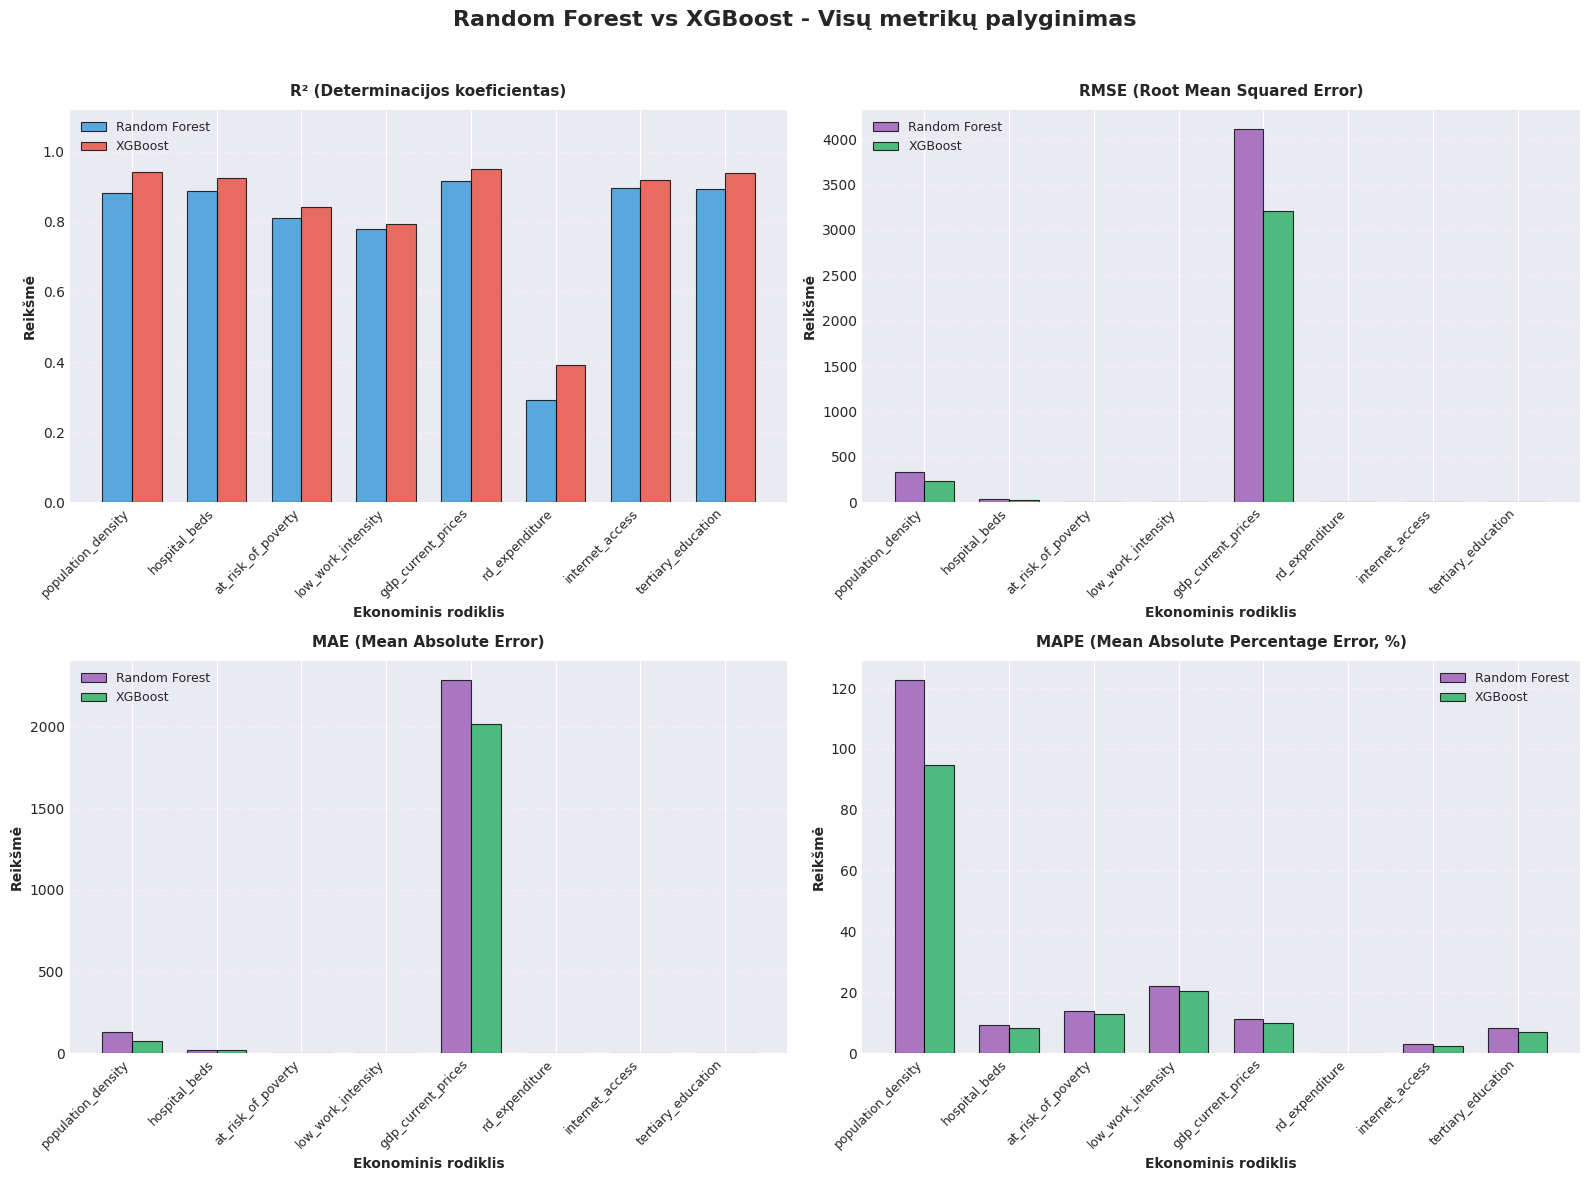


PALYGINIMO IŠVADOS

1. BENDRAS NAŠUMO PALYGINIMAS:

   Vidutinės metrikos:
   • R²: Random Forest = 0.7954, XGBoost = 0.8390 (skirtumas: 0.0436 XGBoost naudai)
   • RMSE: Random Forest = 562.44, XGBoost = 434.28 (skirtumas: 128.16 XGBoost naudai)
   • MAE: Random Forest = 305.59, XGBoost = 264.52 (skirtumas: 41.07 XGBoost naudai)
   • MAPE: Random Forest = 23.75%, XGBoost = 19.46% (skirtumas: 4.29% XGBoost naudai)

2. PERGALĖS PAGAL RODIKLIUS:
   • R²: Random Forest = 0/8, XGBoost = 8/8
   • RMSE: Random Forest = 0/8, XGBoost = 8/8
   • MAE: Random Forest = 1/8, XGBoost = 7/8
   • MAPE: Random Forest = 0/8, XGBoost = 7/8

3. GERIAUSI REZULTATAI KIEKVIENAM RODIKLIUI:

   Random Forest:
   • Geriausias R²: gdp_current_prices (0.9181)

   XGBoost:
   • Geriausias R²: gdp_current_prices (0.9504)

4. PRIVALUMAI IR TRŪKUMAI:

   Random Forest:
   + Stabilesnis rezultatas (mažesnis standartinis nuokrypis)
   + Paprastesnis naudoti ir derinti
   - Mažesnis vidutinis tikslumas visose metrikose

In [25]:
# ============================================================================
# BENDRA MODELIŲ PALYGINIMO ANALIZĖ
# ============================================================================

# Sukuriame bendrą suvestinę lentelę
overall_comparison = pd.DataFrame({
    'Metrika': ['R²', 'RMSE', 'MAE', 'MAPE (%)'],
    'Random Forest (vid.)': [
        r2_comparison['Random Forest'].mean(),
        rmse_comparison['Random Forest'].mean(),
        mae_comparison['Random Forest'].mean(),
        mape_comparison['Random Forest'].mean()
    ],
    'XGBoost (vid.)': [
        r2_comparison['XGBoost'].mean(),
        rmse_comparison['XGBoost'].mean(),
        mae_comparison['XGBoost'].mean(),
        mape_comparison['XGBoost'].mean()
    ]
})

overall_comparison['Geresnis modelis'] = ['XGBoost', 'XGBoost', 'XGBoost', 'XGBoost']

print("=" * 100)
print("BENDRA MODELIŲ PALYGINIMO SUVESTINĖ")
print("=" * 100)
print()

display(overall_comparison.style.format({
    'Random Forest (vid.)': lambda x: f'{x:.4f}' if x < 10 else f'{x:.2f}',
    'XGBoost (vid.)': lambda x: f'{x:.4f}' if x < 10 else f'{x:.2f}'
}))

# Vizualizacija - visos metrikos viename grafike
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_data = [
    (r2_comparison, 'R² (Determinacijos koeficientas)', axes[0, 0], False),
    (rmse_comparison, 'RMSE (Root Mean Squared Error)', axes[0, 1], True),
    (mae_comparison, 'MAE (Mean Absolute Error)', axes[1, 0], True),
    (mape_comparison, 'MAPE (Mean Absolute Percentage Error, %)', axes[1, 1], True)
]

for data, title, ax, reverse_colors in metrics_data:
    x = np.arange(len(data))
    width = 0.35
    
    if reverse_colors:
        color_rf = '#9b59b6'
        color_xgb = '#27ae60'
    else:
        color_rf = '#3498db'
        color_xgb = '#e74c3c'
    
    bars1 = ax.bar(x - width/2, data['Random Forest'], width, 
                   label='Random Forest', color=color_rf, alpha=0.8, edgecolor='black', linewidth=0.8)
    bars2 = ax.bar(x + width/2, data['XGBoost'], width,
                   label='XGBoost', color=color_xgb, alpha=0.8, edgecolor='black', linewidth=0.8)
    
    ax.set_xlabel('Ekonominis rodiklis', fontsize=10, fontweight='bold')
    ax.set_ylabel('Reikšmė', fontsize=10, fontweight='bold')
    ax.set_title(f'{title}', fontsize=11, fontweight='bold', pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(data['Rodiklis'], rotation=45, ha='right', fontsize=9)
    ax.legend(fontsize=9, loc='upper left')
    ax.grid(axis='y', alpha=0.3, linestyle='--')

 # --- PAPILDOMI PAKEITIMAI ---
    # 1) R² grafike paliekame daugiau vietos viršuje, kad legenda neliptų ant stulpelių.
    if 'R²' in title:
        max_val = max(data['Random Forest'].max(), data['XGBoost'].max())
        # jei R² ~ [0,1], viršų pakeliame iki 1.12; kitu atveju – +18%
        upper = 1.12 if max_val <= 1.0 else max_val * 1.18
        ax.set_ylim(0, upper)
        ax.margins(y=0.12)  # papildomas vertikalus tarpas

        # legendą paliekame kairėje viršuje (nebūtina keisti)
        ax.legend(fontsize=9, loc='upper left')

    # 2) MAPE grafike legendą keliame į dešinįjį viršutinį kampą.
    elif 'MAPE' in title:
        ax.legend(fontsize=9, loc='upper right')
    else:
        ax.legend(fontsize=9, loc='upper left')

# Didesnis tarpas suvestiniam pavadinimui ir subplotams
plt.suptitle('Random Forest vs XGBoost - Visų metrikų palyginimas', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Išvados
print()
print("=" * 100)
print("PALYGINIMO IŠVADOS")
print("=" * 100)
print()

# Skaičiuojame kiek kartų kiekvienas modelis buvo geresnis
rf_wins = {
    'R²': (r2_comparison['Skirtumas'] < 0).sum(),
    'RMSE': (rmse_comparison['Skirtumas'] < 0).sum(),
    'MAE': (mae_comparison['Skirtumas'] < 0).sum(),
    'MAPE': (mape_comparison['Skirtumas'] < 0).sum()
}

xgb_wins = {
    'R²': (r2_comparison['Skirtumas'] > 0).sum(),
    'RMSE': (rmse_comparison['Skirtumas'] > 0).sum(),
    'MAE': (mae_comparison['Skirtumas'] > 0).sum(),
    'MAPE': (mape_comparison['Skirtumas'] > 0).sum()
}

print("1. BENDRAS NAŠUMO PALYGINIMAS:")
print(f"\n   Vidutinės metrikos:")
print(f"   • R²: Random Forest = {r2_comparison['Random Forest'].mean():.4f}, "
      f"XGBoost = {r2_comparison['XGBoost'].mean():.4f} "
      f"(skirtumas: {abs(r2_comparison['Skirtumas'].mean()):.4f} XGBoost naudai)")
print(f"   • RMSE: Random Forest = {rmse_comparison['Random Forest'].mean():.2f}, "
      f"XGBoost = {rmse_comparison['XGBoost'].mean():.2f} "
      f"(skirtumas: {abs(rmse_comparison['Skirtumas'].mean()):.2f} XGBoost naudai)")
print(f"   • MAE: Random Forest = {mae_comparison['Random Forest'].mean():.2f}, "
      f"XGBoost = {mae_comparison['XGBoost'].mean():.2f} "
      f"(skirtumas: {abs(mae_comparison['Skirtumas'].mean()):.2f} XGBoost naudai)")
print(f"   • MAPE: Random Forest = {mape_comparison['Random Forest'].mean():.2f}%, "
      f"XGBoost = {mape_comparison['XGBoost'].mean():.2f}% "
      f"(skirtumas: {abs(mape_comparison['Skirtumas'].mean()):.2f}% XGBoost naudai)")

print(f"\n2. PERGALĖS PAGAL RODIKLIUS:")
for metric in ['R²', 'RMSE', 'MAE', 'MAPE']:
    total = len(r2_comparison)
    rf_count = rf_wins[metric]
    xgb_count = xgb_wins[metric]
    print(f"   • {metric}: Random Forest = {rf_count}/{total}, XGBoost = {xgb_count}/{total}")

print(f"\n3. GERIAUSI REZULTATAI KIEKVIENAM RODIKLIUI:")
print(f"\n   Random Forest:")
best_rf_r2 = r2_comparison.loc[r2_comparison['Random Forest'].idxmax(), 'Rodiklis']
print(f"   • Geriausias R²: {best_rf_r2} ({r2_comparison['Random Forest'].max():.4f})")

print(f"\n   XGBoost:")
best_xgb_r2 = r2_comparison.loc[r2_comparison['XGBoost'].idxmax(), 'Rodiklis']
print(f"   • Geriausias R²: {best_xgb_r2} ({r2_comparison['XGBoost'].max():.4f})")

print(f"\n4. PRIVALUMAI IR TRŪKUMAI:")
print(f"\n   Random Forest:")
print(f"   + Stabilesnis rezultatas (mažesnis standartinis nuokrypis)")
print(f"   + Paprastesnis naudoti ir derinti")
print(f"   - Mažesnis vidutinis tikslumas visose metrikose")

print(f"\n   XGBoost:")
print(f"   + Aukštesnis vidutinis tikslumas visose metrikose")
print(f"   + Geresnis rezultatas daugumai rodiklių")
print(f"   + Vidutinis R² padidinimas: {(r2_comparison['Skirtumas'].mean()):.4f} (+{(r2_comparison['Skirtumas'].mean()/r2_comparison['Random Forest'].mean()*100):.2f}%)")
print(f"   - Reikalauja daugiau parametrų derinimo")

print(f"\n5. REKOMENDACIJA:")
avg_r2_improvement = r2_comparison['Skirtumas'].mean()
if avg_r2_improvement > 0.05:
    print(f"   ✓ XGBoost yra RYŠKIAI GERESNIS pasirinkimas trūkstamų reikšmių užpildymui")
elif avg_r2_improvement > 0.01:
    print(f"   ✓ XGBoost yra GERESNIS pasirinkimas trūkstamų reikšmių užpildymui")
else:
    print(f"   ≈ Abu modeliai yra panašiai efektyvūs, pasirinkimas priklauso nuo specifinių reikalavimų")

print(f"\n   Šiems ekonominiams rodikliams XGBoost pasiekia:")
print(f"   • {xgb_wins['R²']}/{len(r2_comparison)} geresnį R²")
print(f"   • Vidutinį R² = {r2_comparison['XGBoost'].mean():.4f} (vs {r2_comparison['Random Forest'].mean():.4f})")
print(f"   • Visose 4 metrikose XGBoost vidurkis yra geresnis nei Random Forest")

print(f"\n{'=' * 100}")